# Data processing 

The goal of this notebook is to build further on the insights we got from our **0. Data exploration.ipynb** notebook. More specifically we will iteratively inspect and correct for data anomalies. For this we will make extensive use of our ride_stats_calculation.py file and our graph_ride_anomalies.py files which we briefly introduced in our previous notebook. 

Part of dealing with anomalies will be rather rule / decision based and part is algorithmically based in which visual inspection played a big role.

### Import libraries

In [45]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 999

import pickle
import numpy as np

import gc
import json

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

# visualisations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# import custom functions
from ride_stats_calculation import ride_stats_calculation
from graph_ride_anomalies import graph_ride_anomalies

### Read in data files for rider 1

In [46]:
# Read in the configuration file

with open('rider_config.json', 'r') as c:
   rider_params = json.load(c)["rider_params"]

In [47]:
# rider files

start_time = datetime.now()

# Load pickle file created in notebook 0. Data exploration.ipynb
df_raw = pd.read_pickle('df_raw.pkl')

print('Shape of dataframe', df_raw.shape)
print('Number of unique rides rider 1',df_raw.filename.nunique())

print('Time processing', datetime.now()-start_time)

Shape of dataframe (4466561, 9)
Number of unique rides rider 1 839
Time processing 0:00:00.846963


### Calculate ride stats
These are calculated to give an overall view of the rides and to spot possible issues with the data. Insight in this will help in taking actions towards possible issues

In [48]:
# We first overwrite hr data to zero to indicate single heart rate (hr) anomalies either below the rest heart rate and above the maximum heart rate
# The purpose is for further processing later

df_raw['hr'] = np.where(((df_raw['hr']<rider_params['rider_min_hr']) | (df_raw['hr']>rider_params['rider_max_hr'])), 0, df_raw['hr'])

# add indicator hr_power is zero (complete dropouts / either from caused by heart rate anomaly)
df_raw['hr_power_zero'] = np.where((df_raw['hr']==0) & (df_raw['watts'] == 0) , 0,1)
df_raw['hr_power_ratio'] = np.round(df_raw['watts']/df_raw['hr']*100, 2)

# add some indicators for consecutive similar values for variables that might be used for modelling further
df_raw['consecutive_hr_similar_values'] = df_raw.hr.groupby([df_raw.filename, df_raw.hr.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_power_similar_values'] = df_raw.watts.groupby([df_raw.filename, df_raw.watts.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_cad_similar_values'] = df_raw.cad.groupby([df_raw.filename, df_raw.cad.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_hr_power_ratio_similar_values'] = df_raw.hr_power_ratio.groupby([df_raw.filename, df_raw.hr_power_ratio.diff().ne(0).cumsum()]).transform('size')

In [49]:
# invoke function
df_stats = ride_stats_calculation(df_raw)
df_stats.head(5)

filename  count_records     mean_hr   mean_cad  mean_power  \
0  2017_01_02_20_00_03.csv           3663  151.017472  84.502594  251.849850   
1  2017_01_03_20_07_36.csv           3065  146.652202  82.800653  255.368352   
2  2017_01_07_19_57_46.csv           5293  142.624410  86.448139  210.336671   
3  2017_01_08_18_02_53.csv           3519  142.388463  75.014493  222.116510   
4  2017_01_10_19_48_18.csv           3622  133.202374  83.098564  196.522363   

   mean_temp   mean_alt  mean_slope  min_hr  max_hr  min_cad  max_cad  \
0   7.180726  -9.969206    0.008655      50     175        0      103   
1   8.397716  33.758238    0.051991     100     170        0       97   
2   6.716229   0.929567   -0.007630      47     167        0      110   
3   9.913328  15.693549    0.014682      59     168        0       98   
4  10.163722   2.162120   -0.003196      74     174        0      103   

   min_power  max_power  min_temp  max_temp  min_alt  max_alt  min_slope  \
0          0        375         6        14    -11.6     -8.6  -1.835940   
1          0        363         7        16     29.2     37.6  -1.407380   
2          0        433         5        15     -0.4      1.8  -8.771930   
3          0        380         9        17     14.0     17.4  -0.932401   
4          0        369         9        16      0.8      3.8  -0.611377   

   max_slope     std_hr     std_power  cv_hr  cv_power  count_zero_hr  \
0   1.384620  20.396807   7926.911911   0.14     31.47              0   
1   1.398600  16.084239   6477.967732   0.11     25.37              0   
2   8.733620  16.316487   8200.055187   0.11     38.99              0   
3   0.943315  18.175116  11744.222351   0.13     52.87              0   
4   7.299270  21.004797   9691.451447   0.16     49.31              0   

   count_zero_cad  count_zero_power  perc_count_zero_hr  perc_count_zero_cad  \
0              70               132                 0.0                  2.0   
1              38                92                 0.0                  1.0   
2             373               661                 0.0                  7.0   
3             285               496                 0.0                  8.0   
4             167               312                 0.0                  5.0   

   perc_count_zero_power  count_zero_hr_power  perc_count_zero_hr_power  \
0                    4.0                    0                       0.0   
1                    3.0                    0                       0.0   
2                   12.0                    0                       0.0   
3                   14.0                    0                       0.0   
4                    9.0                    0                       0.0   

   hr_longest_zero_run  cad_longest_zero_run  power_longest_zero_run  \
0                    0                     6                       7   
1                    0                     6                       7   
2                    0                    11                      14   
3                    0                    12                      16   
4                    0                    20                      21   

   perc_hr_longest_zero_run  perc_cad_longest_zero_run  \
0                       0.0                        0.0   
1                       0.0                        0.0   
2                       0.0                        0.0   
3                       0.0                        0.0   
4                       0.0                        1.0   

   perc_power_longest_zero_run  count_power_extremes  count_cad_extremes  \
0                          0.0                     0                   0   
1                          0.0                     0                   0   
2                          0.0                     0                   0   
3                          0.0                     0                   0   
4                          1.0                     0                   0   

   perc_power_extremes  perc_ca

### Remove records in ride stats and corresponding ride files which do not have data for heart rate (hr) and power (watts)

In [50]:
# Remove all rides with no heart rate data (our target variable) at all in the ride since this is our target variable

print('We had', df_stats.shape[0], 'ride files')
df_stats = df_stats[~df_stats.filename.isin(df_stats['filename'].loc[df_stats.mean_hr==0])];
print('We now have', df_stats.filename.nunique(), 'ride files')

#remove in stats table
df_stats = df_stats.loc[df_stats.mean_hr>0];

We had 839 ride files
We now have 812 ride files


In [51]:
# Remove all rides with no power/cadence data at all in the ride since these are our main independent variables

print('We had', df_stats.shape[0], 'ride files')
df_stats = df_stats[~df_stats.filename.isin(df_stats['filename'].loc[(df_stats.mean_power==0) | (df_stats.mean_cad==0)])];
print('We now have', df_stats.filename.nunique(), 'ride files')

#remove in stats table
df_stats = df_stats.loc[(df_stats.mean_power>0) & (df_stats.mean_cad>0)];

We had 812 ride files
We now have 786 ride files


In [53]:
# keep rides from df_stats in df_raw

print('We had', df_raw.filename.nunique(), 'ride files')
df_raw = df_raw.loc[df_raw.filename.isin(df_stats.filename.unique())]
print('We now have', df_raw.filename.nunique(), 'ride files')

We had 839 ride files
We now have 786 ride files


## Iteration 1

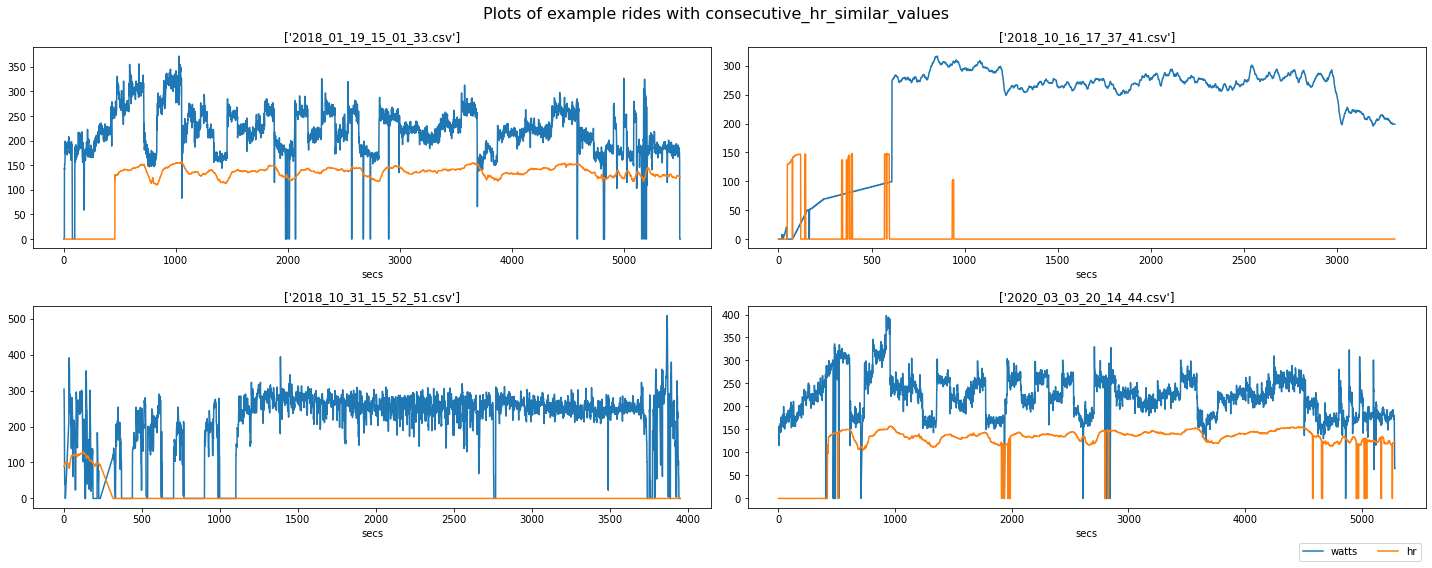

In [54]:
graph_ride_anomalies(df_raw, df_stats, 4,'consecutive_hr_similar_values', 2, 2)

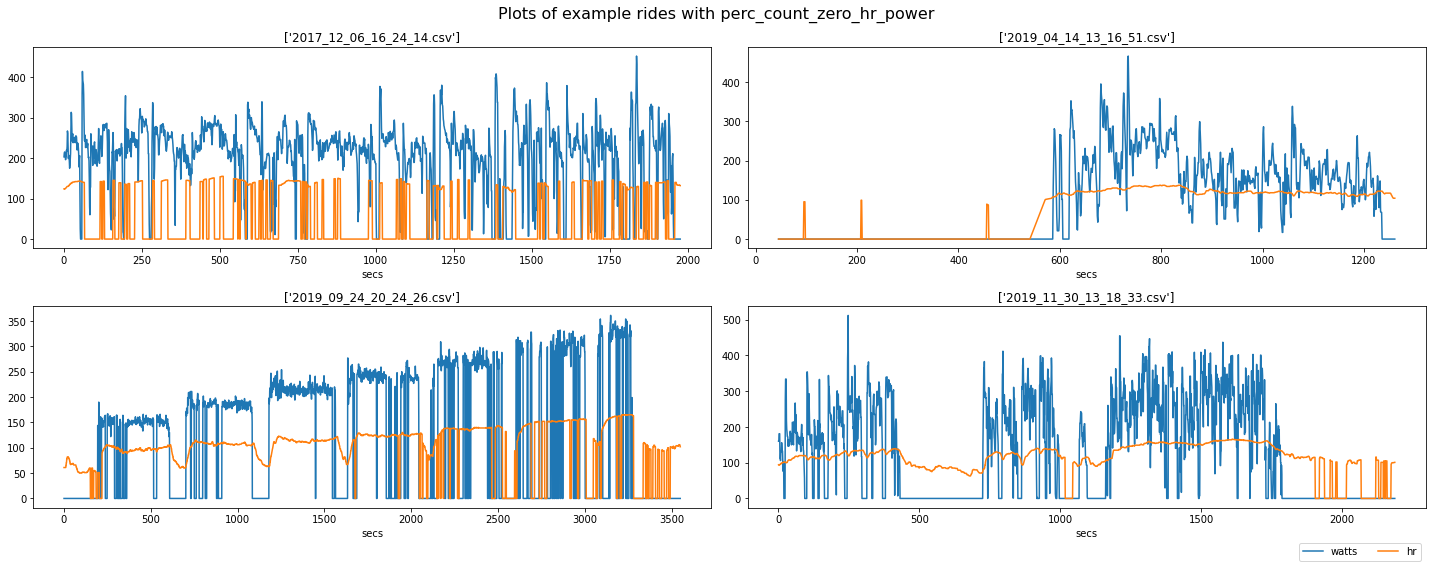

In [55]:
# invoke function
graph_ride_anomalies(df_raw, df_stats, 4,'perc_count_zero_hr_power', 2, 2)

In [56]:
# inspect top 5 rides with power data but with a long ranges of zero power and zero heart rate

df_stats.loc[df_stats.perc_count_zero_hr_power>0].sort_values(by=['perc_count_zero_hr_power'], ascending = False).head(5)

filename  count_records     mean_hr   mean_cad  \
479  2019_04_14_13_16_51.csv            946   87.848837  56.548626   
574  2019_09_24_20_24_26.csv           3542   99.191700  42.393281   
617  2019_11_30_13_18_33.csv           2184  113.052198  44.471154   
187  2017_12_06_16_24_14.csv           1975   53.591899  79.561013   
766  2020_08_17_19_12_15.csv           2607  109.602992  81.481013   

     mean_power  mean_temp    mean_alt  mean_slope  min_hr  max_hr  min_cad  \
479  120.482030  12.712474 -173.736786    0.052770       0     137        0   
574  118.238848  21.450593    7.925805    0.000000       0     165        0   
617  127.098901   9.615385   -0.278388   -0.012503       0     166        0   
187  198.920000  14.547848    4.655494    0.033237       0     155        0   
766  182.700038  23.627158   41.264672   -0.002598       0     136        0   

     max_cad  min_power  max_power  min_temp  max_temp  min_alt  max_alt  \
479      115          0        466        11        15   -176.0   -172.0   
574       92          0        361        21        23      3.2     11.6   
617      109          0        512         9        10     -2.4      0.2   
187      104          0        452        14        15     -6.0     10.8   
766      110          0        510        21        28     36.0     46.0   

     min_slope  max_slope     std_hr     std_power  cv_hr  cv_power  \
479   -2.36111   3.666670  54.142917  10593.157878   0.62     87.92   
574    0.00000   0.000000  45.460389  14334.020880   0.46    121.23   
617   -3.05699   0.326264  42.052898  17638.175281   0.37    138.78   
187   -4.56100   3.394370  68.006373   8624.152665   1.27     43.35   
766   -3.02020   3.789680  27.127255   8363.024340   0.25     45.77   

     count_zero_hr  count_zero_cad  count_zero_power  perc_count_zero_hr  \
479            257             310               310                27.0   
574            451            1694              1695                13.0   
617            184             983               996                 8.0   
187           1216             173               187                62.0   
766            113             291               291                 4.0   

     perc_count_zero_cad  perc_count_zero_power  count_zero_hr_power  \
479                 33.0                   33.0                  257   
574                 48.0                   48.0                  375   
617                 45.0                   46.0                  184   
187                  9.0                    9.0                   90   
766                 11.0                   11.0                   99   

     perc_count_zero_hr_power  hr_longest_zero_run  cad_longest_zero_run  \
479                      27.0                  136                   271   
574                      11.0                   55                   277   
617                       8.0                   52                   401   
187                       5.0                   90                    21   
766                       4.0                   99                   109   

     power_longest_zero_run  perc_hr_longest_zero_run  \
479                     271                      14.0   
574                     277                       2.0   
617                     401                       2.0   
187                      22                       5.0   
766                     109                       4.0   

     perc_cad_longest_zero_run  perc_power_longest_zero_run  \
479                       29.0                         29.0   
574                        8.0                          8.0   
617                       18.0                         18.0   
187                        1.0                          1.0   
766                        4.0                          4.0   

     count_power_extremes  count_cad_extremes  perc_power_extremes  \
479                     0                   0                  0.0   
574                     0      

**Observations**

We see rides with sudden dropout for heart rate for longer periods with or without dropouts in combination with power dropouts. The second example seems a file with power dropouts within structured intervals

In [57]:
# inspect top 10 rides with power data but with a long ranges of zero power

df_stats.loc[df_stats.mean_power>0].sort_values(by=['power_longest_zero_run'], ascending = False).head(5)

filename  count_records     mean_hr   mean_cad  \
742  2020_07_20_15_19_41.csv           4697  104.503939  16.120502   
422  2019_01_10_15_00_39.csv           4205  145.451130  39.145065   
393  2018_11_18_14_29_00.csv           1216  112.824013  51.120888   
617  2019_11_30_13_18_33.csv           2184  113.052198  44.471154   
781  2020_09_13_08_04_44.csv          14034  135.239347  80.474847   

     mean_power  mean_temp   mean_alt  mean_slope  min_hr  max_hr  min_cad  \
742   20.584416  24.908878 -27.528550    0.137164      61     144        0   
422  131.525327   2.517479  18.210083    0.374261      79     174        0   
393  124.141447   4.012336  -0.830921    0.054773      71     147        0   
617  127.098901   9.615385  -0.278388   -0.012503       0     166        0   
781  192.408579  18.234502  85.536868    0.017927      64     170        0   

     max_cad  min_power  max_power  min_temp  max_temp  min_alt  max_alt  \
742       87          0        297        23        28    -33.8    -10.4   
422      145          0        952         1         8     11.4     30.6   
393      115          0        603         3         8     -4.2      1.6   
617      109          0        512         9        10     -2.4      0.2   
781      149          0        953        11        23      0.0    100.2   

     min_slope  max_slope     std_hr     std_power  cv_hr  cv_power  \
742   -5.73362   9.743170  14.224848   1679.234408   0.14     81.58   
422  -18.90090  19.672100  19.773944  27158.437810   0.14    206.49   
393   -1.23483   3.129890  23.009898  19718.860635   0.20    158.84   
617   -3.05699   0.326264  42.052898  17638.175281   0.37    138.78   
781   -4.30696   5.094920  17.281018  16677.948493   0.13     86.68   

     count_zero_hr  count_zero_cad  count_zero_power  perc_count_zero_hr  \
742              0            3288              3515                 0.0   
422              0            1828              2036                 0.0   
393              0             561               605                 0.0   
617            184             983               996                 8.0   
781              0             773              1394                 0.0   

     perc_count_zero_cad  perc_count_zero_power  count_zero_hr_power  \
742                 70.0                   75.0                    0   
422                 43.0                   48.0                    0   
393                 46.0                   50.0                    0   
617                 45.0                   46.0                  184   
781                  6.0                   10.0                    0   

     perc_count_zero_hr_power  hr_longest_zero_run  cad_longest_zero_run  \
742                       0.0                    0                  2129   
422                       0.0                    0                   585   
393                       0.0                    0                   478   
617                       8.0                   52                   401   
781                       0.0                    0                   368   

     power_longest_zero_run  perc_hr_longest_zero_run  \
742                    2131                       0.0   
422                     587                       0.0   
393                     480                       0.0   
617                     401                       2.0   
781                     368                       0.0   

     perc_cad_longest_zero_run  perc_power_longest_zero_run  \
742                       45.0                         45.0   
422                       14.0                         14.0   
393                       39.0                         39.0   
617                       18.0                         18.0   
781                        3.0                          3.0   

     count_power_extremes  count_cad_extremes  perc_power_extremes  \
742                     0                   0                  0.0   
422                     0            

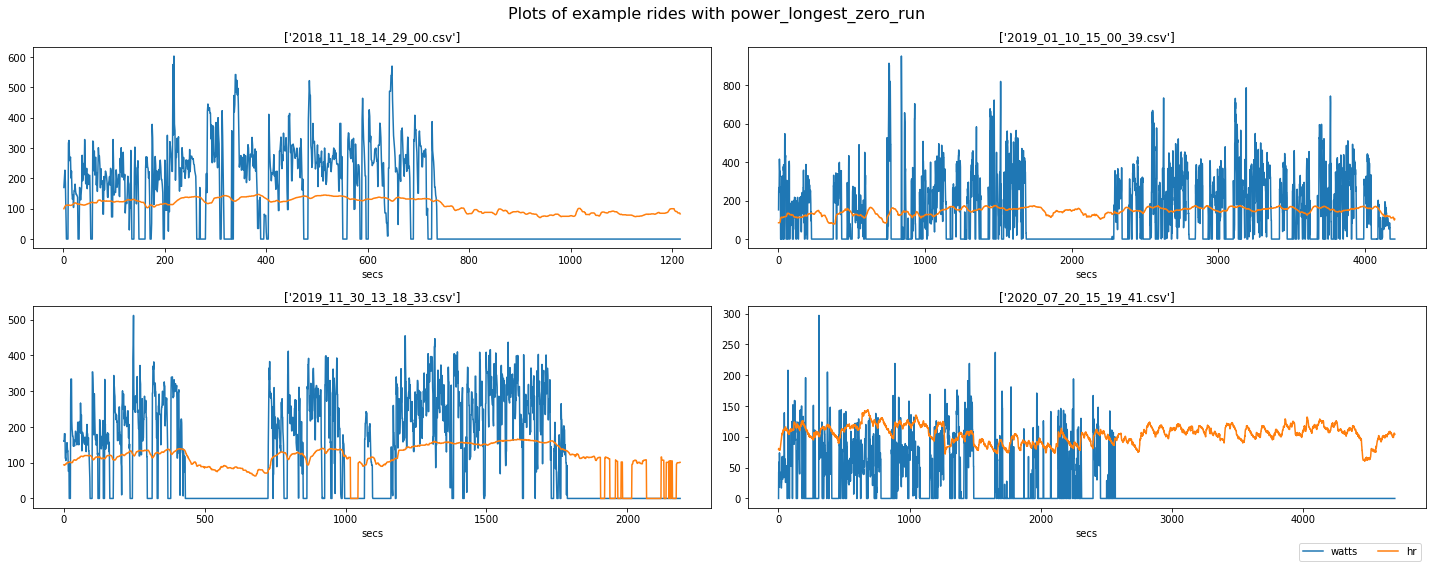

In [58]:
# invoke function
graph_ride_anomalies(df_raw, df_stats, 4,'power_longest_zero_run', 2, 2)

**Observations**

We observe a.o. no power at the end of rides while heart rate does seem to record. We will delete those parts in the files. Meaning when we observe zero power at the end AND at the beginning. Later we have to see how we deal with dropout data within the rides

In [59]:
# Add the longest range from start and the end with no wattage data and remove! Can be based on no data, starting, forget to stop

start_time = datetime.now()

print('We had', df_raw.shape[0], 'observations')  

# This only keeps records which have power data. In rider 1 case 1641 out of 1706 rides
df_raw_1_1 = pd.DataFrame()
for i in df_raw.filename.unique():
    X = df_raw.loc[df_raw['filename'] ==i]
    X = X[(X.watts.eq(0).cumprod().eq(0)) & (X.watts[::-1].eq(0).cumprod().eq(0))] 
    df_raw_1_1 = df_raw_1_1.append(X,ignore_index=True)

   
# Free memory from old df_raw
del df_raw
gc.collect()
    
# Do the same thing for heart rate
df_raw_1_2 = pd.DataFrame()
for i in df_raw_1_1.filename.unique():
    X = df_raw_1_1.loc[df_raw_1_1['filename'] ==i]
    X = X[(X.hr.eq(0).cumprod().eq(0)) & (X.hr[::-1].eq(0).cumprod().eq(0))] 
    df_raw_1_2 = df_raw_1_2.append(X,ignore_index=True)

# Free memory from df_raw_1_1
del df_raw_1_1
gc.collect()    

df_raw = df_raw_1_2.copy()

print('We now have', df_raw.shape[0], 'observations')   

# delete  from df_raw_1_2
del df_raw_1_2
gc.collect()

print('Time processing', datetime.now()-start_time)

We had 4208970 observations
We now have 4189410 observations
Time processing 0:16:05.077420


## Iteration 2

In [60]:
# since we deleted records we re-calculate the seconds in the ride. We do this for plotting purposes mainly

df_raw['secs'] = df_raw.groupby('filename').cumcount()+1

# first add indicator hr_power is zero (complete dropouts)

df_raw['hr_power_zero'] = np.where((df_raw['hr']==0) & (df_raw['watts'] == 0) , 0,1)
df_raw['hr_power_ratio'] = np.round(df_raw['watts']/df_raw['hr']*100, 2)

# add some indicators for consecutive similar values for variables that might be used for modelling further
df_raw['consecutive_hr_similar_values'] = df_raw.hr.groupby([df_raw.filename, df_raw.hr.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_power_similar_values'] = df_raw.watts.groupby([df_raw.filename, df_raw.watts.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_cad_similar_values'] = df_raw.cad.groupby([df_raw.filename, df_raw.cad.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_hr_power_ratio_similar_values'] = df_raw.hr_power_ratio.groupby([df_raw.filename, df_raw.hr_power_ratio.diff().ne(0).cumsum()]).transform('size')

# apply the function for ride statistics
df_stats = ride_stats_calculation(df_raw)
df_stats.head(5)

filename  count_records     mean_hr   mean_cad  mean_power  \
0  2017_01_02_20_00_03.csv           3653  151.170819  84.703258  252.539283   
1  2017_01_03_20_07_36.csv           3065  146.652202  82.800653  255.368352   
2  2017_01_07_19_57_46.csv           5286  142.734960  86.547295  210.615210   
3  2017_01_08_18_02_53.csv           3514  142.485771  75.098463  222.432555   
4  2017_01_10_19_48_18.csv           3613  133.324661  83.260172  197.011901   

   mean_temp   mean_alt  mean_slope  min_hr  max_hr  min_cad  max_cad  \
0   7.175198  -9.970600    0.008560      50     175        0      103   
1   8.397716  33.758238    0.051991     100     170        0       97   
2   6.706773   0.929550   -0.007759      49     167        0      110   
3   9.905521  15.694878    0.014576      59     168        0       98   
4  10.152505   2.161915   -0.003398      80     174        0      103   

   min_power  max_power  min_temp  max_temp  min_alt  max_alt  min_slope  \
0          0        375         6        14    -11.6     -8.6  -1.835940   
1          0        363         7        16     29.2     37.6  -1.407380   
2          0        433         5        15     -0.4      1.8  -2.824860   
3          0        380         9        17     14.0     17.4  -0.932401   
4          0        369         9        16      0.8      3.8  -0.611377   

   max_slope     std_hr     std_power  cv_hr  cv_power  count_zero_hr  \
0   1.384620  20.121043   7774.461011   0.13     30.79              0   
1   1.398600  16.084239   6477.967732   0.11     25.37              0   
2   2.869440  16.010023   8152.240556   0.11     38.71              0   
3   0.943315  17.973902  11690.618991   0.13     52.56              0   
4   7.299270  20.874355   9619.128042   0.16     48.83              0   

   count_zero_cad  count_zero_power  perc_count_zero_hr  perc_count_zero_cad  \
0              62               122                 0.0                  2.0   
1              38                92                 0.0                  1.0   
2             367               654                 0.0                  7.0   
3             281               491                 0.0                  8.0   
4             160               303                 0.0                  4.0   

   perc_count_zero_power  count_zero_hr_power  perc_count_zero_hr_power  \
0                    3.0                    0                       0.0   
1                    3.0                    0                       0.0   
2                   12.0                    0                       0.0   
3                   14.0                    0                       0.0   
4                    8.0                    0                       0.0   

   hr_longest_zero_run  cad_longest_zero_run  power_longest_zero_run  \
0                    0                     6                       7   
1                    0                     6                       7   
2                    0                    11                      14   
3                    0                    12                      16   
4                    0                    20                      21   

   perc_hr_longest_zero_run  perc_cad_longest_zero_run  \
0                       0.0                        0.0   
1                       0.0                        0.0   
2                       0.0                        0.0   
3                       0.0                        0.0   
4                       0.0                        1.0   

   perc_power_longest_zero_run  count_power_extremes  count_cad_extremes  \
0                          0.0                     0                   0   
1                          0.0                     0                   0   
2                          0.0                     0                   0   
3                          0.0                     0                   0   
4                          1.0                     0                   0   

   perc_power_extremes  perc_ca

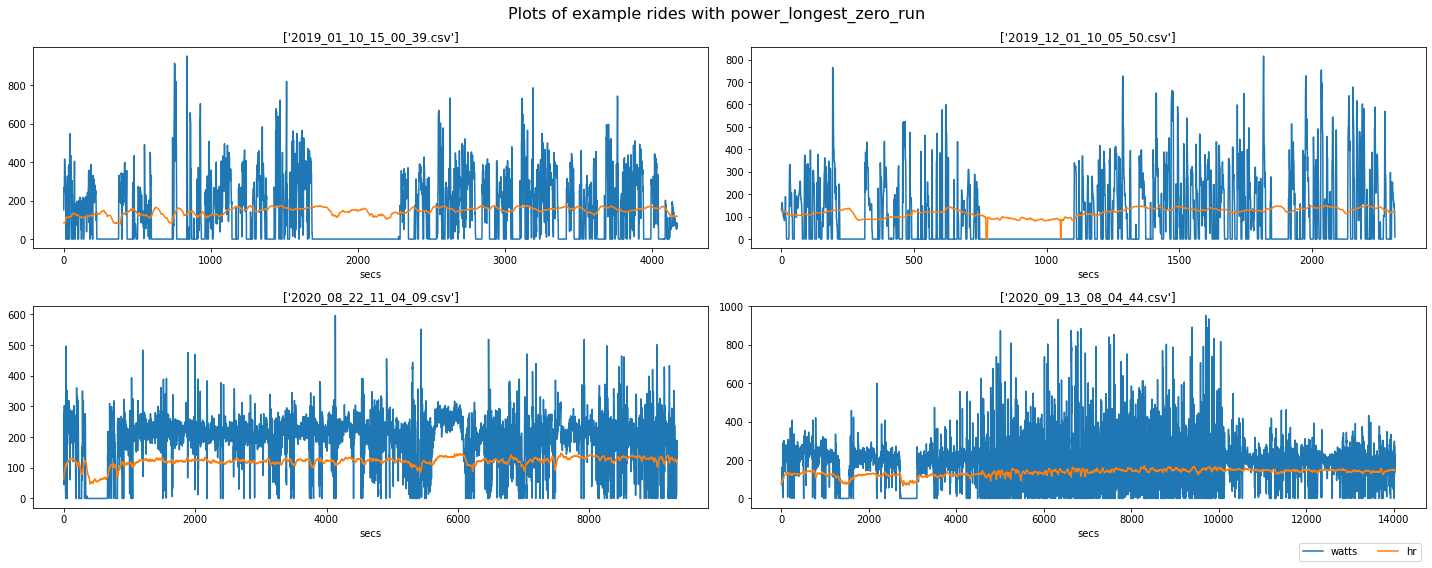

In [61]:
# invoke function
graph_ride_anomalies(df_raw, df_stats, 4,'power_longest_zero_run', 2, 2)

**Observations**

We still want to deal with the larger heart rate dropouts *during* the ride. But let's first deal with the longer data ranges without power. These can be attributed to a lot of factors like standing still for a few minutes (or hours for e.g. when communting and then starting again), but also not pedalling for a while (in a descent). We want to take into account as much data as possible, but for long periods of non-pedalling we want to exclude that data. Let's first do it for power

In [62]:
#procedure for cleaning the long power with zeros
start_time = datetime.now()

df_raw = df_raw.reset_index(drop=True)
s = df_raw.loc[df_raw.watts==0].index.to_series()
start = s[s.diff(1) != 1].reset_index(drop=True)
end = s[s.diff(-1) != -1].reset_index(drop=True)
zero_power_start_end = pd.DataFrame({'start': start, 'end': end}, columns=['start', 'end'])
zero_power_start_end['length_period_zero_watts'] = zero_power_start_end['end'] - zero_power_start_end['start']
zero_power_start_end = zero_power_start_end.loc[zero_power_start_end['length_period_zero_watts']>120]
zero_power_start_end['start_new'] = zero_power_start_end['start'] + 60
zero_power_start_end['end_new'] = zero_power_start_end['end'] - 60

records = zero_power_start_end[['start_new','end_new']].to_records(index=False)
result = list(records)

lijst_tot = []
for pair in result:
    a, b = pair
    lijstje = list(range(a,b))
    lijst_tot.append(lijstje)
    
flat_list = [item for sublist in lijst_tot for item in sublist]

print('Amount of records we had', df_raw.shape[0])

df_raw = df_raw[~df_raw.index.isin(flat_list)]
df_raw = df_raw.reset_index(drop=True)

print('Amount of records we have now', df_raw.shape[0])

print('Time processing', datetime.now()-start_time)

Amount of records we had 4189410
Amount of records we have now 4186118
Time processing 0:00:01.237035


## Iteration 3

In [63]:
# first add indicator hr_power is zero (complete dropouts)

df_raw['secs'] = df_raw.groupby('filename').cumcount()+1

df_raw['hr_power_zero'] = np.where((df_raw['hr']==0) & (df_raw['watts'] == 0) , 0,1)
df_raw['hr_power_ratio'] = np.round(df_raw['watts']/df_raw['hr']*100, 2)

# add some indicators for consecutive similar values for variables that might be used for modelling further
df_raw['consecutive_hr_similar_values'] = df_raw.hr.groupby([df_raw.filename, df_raw.hr.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_power_similar_values'] = df_raw.watts.groupby([df_raw.filename, df_raw.watts.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_cad_similar_values'] = df_raw.cad.groupby([df_raw.filename, df_raw.cad.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_hr_power_ratio_similar_values'] = df_raw.hr_power_ratio.groupby([df_raw.filename, df_raw.hr_power_ratio.diff().ne(0).cumsum()]).transform('size')

# apply the function for ride statistics
df_stats = ride_stats_calculation(df_raw)
df_stats.head(5)

filename  count_records     mean_hr   mean_cad  mean_power  \
0  2017_01_02_20_00_03.csv           3653  151.170819  84.703258  252.539283   
1  2017_01_03_20_07_36.csv           3065  146.652202  82.800653  255.368352   
2  2017_01_07_19_57_46.csv           5286  142.734960  86.547295  210.615210   
3  2017_01_08_18_02_53.csv           3514  142.485771  75.098463  222.432555   
4  2017_01_10_19_48_18.csv           3613  133.324661  83.260172  197.011901   

   mean_temp   mean_alt  mean_slope  min_hr  max_hr  min_cad  max_cad  \
0   7.175198  -9.970600    0.008560      50     175        0      103   
1   8.397716  33.758238    0.051991     100     170        0       97   
2   6.706773   0.929550   -0.007759      49     167        0      110   
3   9.905521  15.694878    0.014576      59     168        0       98   
4  10.152505   2.161915   -0.003398      80     174        0      103   

   min_power  max_power  min_temp  max_temp  min_alt  max_alt  min_slope  \
0          0        375         6        14    -11.6     -8.6  -1.835940   
1          0        363         7        16     29.2     37.6  -1.407380   
2          0        433         5        15     -0.4      1.8  -2.824860   
3          0        380         9        17     14.0     17.4  -0.932401   
4          0        369         9        16      0.8      3.8  -0.611377   

   max_slope     std_hr     std_power  cv_hr  cv_power  count_zero_hr  \
0   1.384620  20.121043   7774.461011   0.13     30.79              0   
1   1.398600  16.084239   6477.967732   0.11     25.37              0   
2   2.869440  16.010023   8152.240556   0.11     38.71              0   
3   0.943315  17.973902  11690.618991   0.13     52.56              0   
4   7.299270  20.874355   9619.128042   0.16     48.83              0   

   count_zero_cad  count_zero_power  perc_count_zero_hr  perc_count_zero_cad  \
0              62               122                 0.0                  2.0   
1              38                92                 0.0                  1.0   
2             367               654                 0.0                  7.0   
3             281               491                 0.0                  8.0   
4             160               303                 0.0                  4.0   

   perc_count_zero_power  count_zero_hr_power  perc_count_zero_hr_power  \
0                    3.0                    0                       0.0   
1                    3.0                    0                       0.0   
2                   12.0                    0                       0.0   
3                   14.0                    0                       0.0   
4                    8.0                    0                       0.0   

   hr_longest_zero_run  cad_longest_zero_run  power_longest_zero_run  \
0                    0                     6                       7   
1                    0                     6                       7   
2                    0                    11                      14   
3                    0                    12                      16   
4                    0                    20                      21   

   perc_hr_longest_zero_run  perc_cad_longest_zero_run  \
0                       0.0                        0.0   
1                       0.0                        0.0   
2                       0.0                        0.0   
3                       0.0                        0.0   
4                       0.0                        1.0   

   perc_power_longest_zero_run  count_power_extremes  count_cad_extremes  \
0                          0.0                     0                   0   
1                          0.0                     0                   0   
2                          0.0                     0                   0   
3                          0.0                     0                   0   
4                          1.0                     0                   0   

   perc_power_extremes  perc_ca

In [64]:
# inspect top 5 rides with power data but with a long ranges of zero power and zero HR. Longest periods is now 121 seconds
df_stats.loc[df_stats.power_longest_zero_run>0][['filename','count_records','power_longest_zero_run']].sort_values(by=['power_longest_zero_run'], ascending = False).head(5)

filename  count_records  power_longest_zero_run
634  2020_03_22_09_33_46.csv          19351                     121
312  2018_07_23_07_33_28.csv           8331                     121
311  2018_07_22_07_33_06.csv           8423                     121
553  2019_10_19_10_03_14.csv           1369                     121
552  2019_10_17_18_28_41.csv           4216                     121

In [65]:
# inspect top 5 rides with power data but with a long ranges of zero power and zero HR
df_stats.loc[df_stats.perc_count_zero_hr_power>0][['filename','count_records','perc_count_zero_hr','count_zero_hr','power_longest_zero_run','perc_count_zero_power']].sort_values(by=['perc_count_zero_power'], ascending = False).head(5)

filename  count_records  perc_count_zero_hr  \
596  2020_01_05_13_07_04.csv           8185                 4.0   
541  2019_09_24_20_24_26.csv           3071                10.0   
575  2019_11_30_13_18_33.csv           1610                 2.0   
139  2017_09_08_20_22_26.csv           1961                 2.0   
192  2017_12_30_18_09_48.csv           3523                 2.0   

     count_zero_hr  power_longest_zero_run  perc_count_zero_power  
596            292                     121                   46.0  
541            299                      96                   40.0  
575             27                     121                   26.0  
139             31                      32                   22.0  
192             70                      43                   19.0

In [66]:
df_stats[['filename','count_records','perc_count_zero_hr','count_zero_hr','power_longest_zero_run','perc_count_zero_power']].sort_values(by='perc_count_zero_power', ascending=False).head(5)

filename  count_records  perc_count_zero_hr  \
267  2018_05_10_14_43_20.csv           1962                 0.0   
692  2020_07_20_15_19_41.csv           2525                 0.0   
553  2019_10_19_10_03_14.csv           1369                 0.0   
577  2019_12_01_10_05_50.csv           2078                 0.0   
585  2019_12_22_10_30_23.csv           1180                 0.0   

     count_zero_hr  power_longest_zero_run  perc_count_zero_power  
267              0                     121                   62.0  
692              0                     121                   53.0  
553              3                     121                   53.0  
577              8                     121                   52.0  
585              0                     121                   48.0

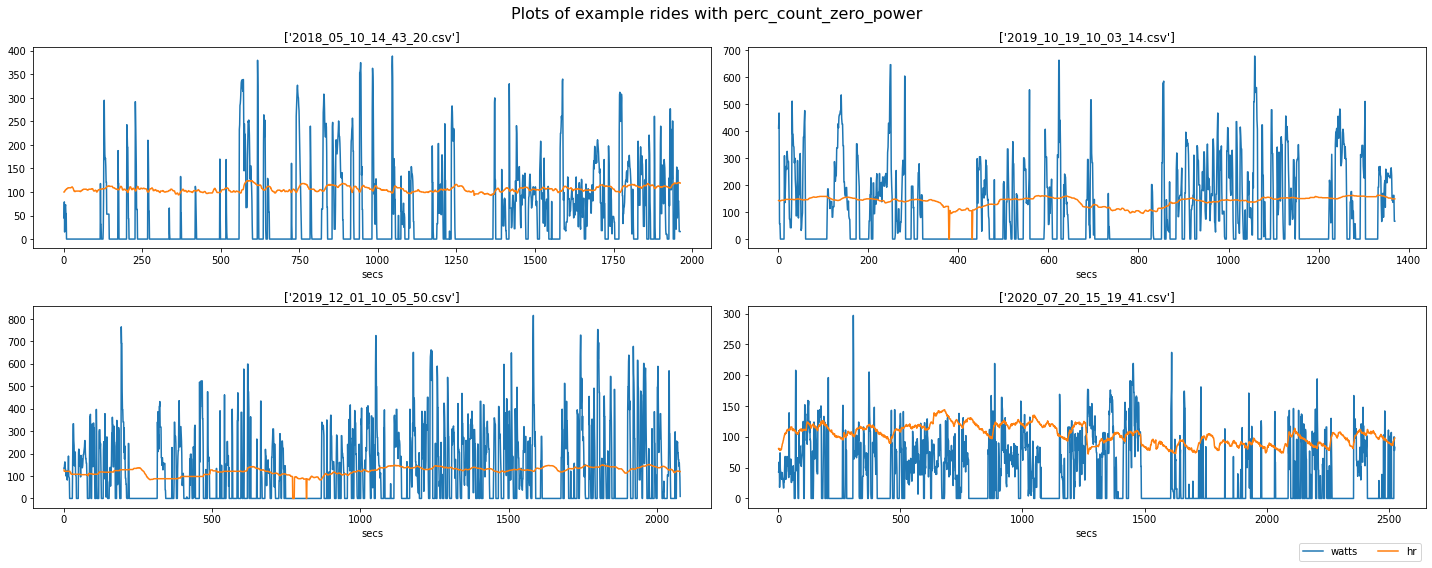

In [68]:
# invoke function
graph_ride_anomalies(df_raw, df_stats, 4,'perc_count_zero_power', 2, 2)

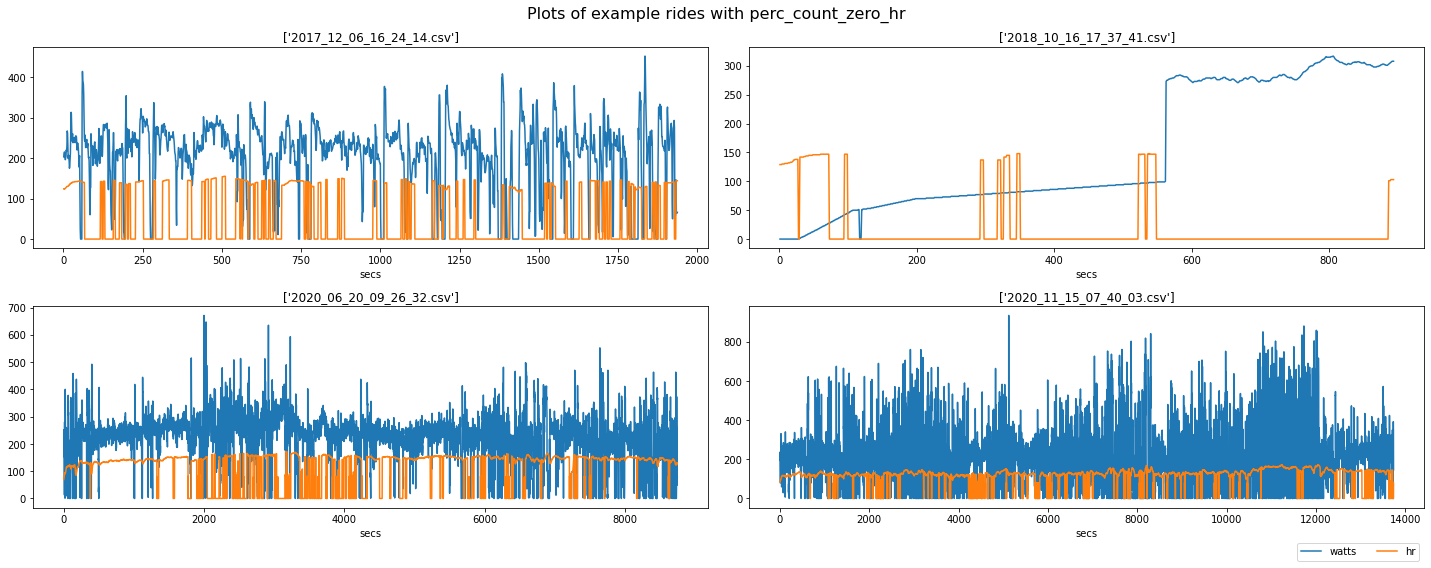

In [69]:
# invoke function
graph_ride_anomalies(df_raw, df_stats, 4,'perc_count_zero_hr', 2, 2)

**Observations**

Even after removing beginning, end with no power data nor in between power data we still have a lager percentage of no heart rate data. We remove ride files and data based on some thresholds

## Iteration 4

In [70]:
# define some maximum values for statistics
threshold_remove_perc_count_zero_hr = 40
threshold_remove_perc_count_zero_power = 60

print('Removed files with less than 60% heart rate of the time', df_stats.shape[0] - df_stats.loc[df_stats.perc_count_zero_hr<threshold_remove_perc_count_zero_hr].shape[0])
df_stats = df_stats.loc[df_stats.perc_count_zero_hr<threshold_remove_perc_count_zero_hr]

print('Removed files with more than 60% of the time no power data', df_stats.shape[0] - df_stats.loc[df_stats.perc_count_zero_power<threshold_remove_perc_count_zero_power].shape[0])
df_stats = df_stats.loc[df_stats.perc_count_zero_power<threshold_remove_perc_count_zero_power]

# reason for this is that for this rider it mainly means small rides which had no real benefit/not out of training perspective
#print('Removed data of rides smaller than 15 min', df_raw_1_stats_2.loc[df_raw_1_stats_2.count_records<900].shape[0])
#df_raw_1_stats_3 = df_raw_1_stats_2.loc[df_raw_1_stats_2.count_records>900]

#remove those files in raw data
cond = df_raw['filename'].isin(df_stats.filename)

print('We had ' ,df_raw.shape[0],'records')

df_raw = df_raw.drop(df_raw[cond==False].index)

print('Now we have ',df_raw.shape[0],'records')

df_raw = df_raw.reset_index(drop=True);

# free menmory
del cond
gc.collect();

Removed files with less than 60% heart rate of the time 2
Removed files with more than 60% of the time no power data 1
We had  4186118 records
Now we have  4181325 records


In [71]:
# apply the function for ride statistics
df_stats = ride_stats_calculation(df_raw)
df_stats.head(5)

filename  count_records     mean_hr   mean_cad  mean_power  \
0  2017_01_02_20_00_03.csv           3653  151.170819  84.703258  252.539283   
1  2017_01_03_20_07_36.csv           3065  146.652202  82.800653  255.368352   
2  2017_01_07_19_57_46.csv           5286  142.734960  86.547295  210.615210   
3  2017_01_08_18_02_53.csv           3514  142.485771  75.098463  222.432555   
4  2017_01_10_19_48_18.csv           3613  133.324661  83.260172  197.011901   

   mean_temp   mean_alt  mean_slope  min_hr  max_hr  min_cad  max_cad  \
0   7.175198  -9.970600    0.008560      50     175        0      103   
1   8.397716  33.758238    0.051991     100     170        0       97   
2   6.706773   0.929550   -0.007759      49     167        0      110   
3   9.905521  15.694878    0.014576      59     168        0       98   
4  10.152505   2.161915   -0.003398      80     174        0      103   

   min_power  max_power  min_temp  max_temp  min_alt  max_alt  min_slope  \
0          0        375         6        14    -11.6     -8.6  -1.835940   
1          0        363         7        16     29.2     37.6  -1.407380   
2          0        433         5        15     -0.4      1.8  -2.824860   
3          0        380         9        17     14.0     17.4  -0.932401   
4          0        369         9        16      0.8      3.8  -0.611377   

   max_slope     std_hr     std_power  cv_hr  cv_power  count_zero_hr  \
0   1.384620  20.121043   7774.461011   0.13     30.79              0   
1   1.398600  16.084239   6477.967732   0.11     25.37              0   
2   2.869440  16.010023   8152.240556   0.11     38.71              0   
3   0.943315  17.973902  11690.618991   0.13     52.56              0   
4   7.299270  20.874355   9619.128042   0.16     48.83              0   

   count_zero_cad  count_zero_power  perc_count_zero_hr  perc_count_zero_cad  \
0              62               122                 0.0                  2.0   
1              38                92                 0.0                  1.0   
2             367               654                 0.0                  7.0   
3             281               491                 0.0                  8.0   
4             160               303                 0.0                  4.0   

   perc_count_zero_power  count_zero_hr_power  perc_count_zero_hr_power  \
0                    3.0                    0                       0.0   
1                    3.0                    0                       0.0   
2                   12.0                    0                       0.0   
3                   14.0                    0                       0.0   
4                    8.0                    0                       0.0   

   hr_longest_zero_run  cad_longest_zero_run  power_longest_zero_run  \
0                    0                     6                       7   
1                    0                     6                       7   
2                    0                    11                      14   
3                    0                    12                      16   
4                    0                    20                      21   

   perc_hr_longest_zero_run  perc_cad_longest_zero_run  \
0                       0.0                        0.0   
1                       0.0                        0.0   
2                       0.0                        0.0   
3                       0.0                        0.0   
4                       0.0                        1.0   

   perc_power_longest_zero_run  count_power_extremes  count_cad_extremes  \
0                          0.0                     0                   0   
1                          0.0                     0                   0   
2                          0.0                     0                   0   
3                          0.0                     0                   0   
4                          1.0                     0                   0   

   perc_power_extremes  perc_ca

In [72]:
# inspect top 5 rides with power data but with a long ranges of zero power and zero HR
df_stats.loc[df_stats.perc_count_zero_hr_power>0][['filename','count_records','perc_count_zero_hr','perc_count_zero_power','perc_count_zero_hr_power']].sort_values(by=['perc_count_zero_hr'], ascending = False).head(5)

filename  count_records  perc_count_zero_hr  \
758  2020_11_15_07_40_03.csv          13739                12.0   
538  2019_09_24_20_24_26.csv           3071                10.0   
192  2018_01_02_20_23_42.csv           2899                 6.0   
366  2018_11_06_20_34_28.csv           2396                 6.0   
177  2017_12_03_11_14_36.csv           6736                 5.0   

     perc_count_zero_power  perc_count_zero_hr_power  
758                   15.0                       1.0  
538                   40.0                       7.0  
192                    2.0                       1.0  
366                    2.0                       1.0  
177                    4.0                       1.0

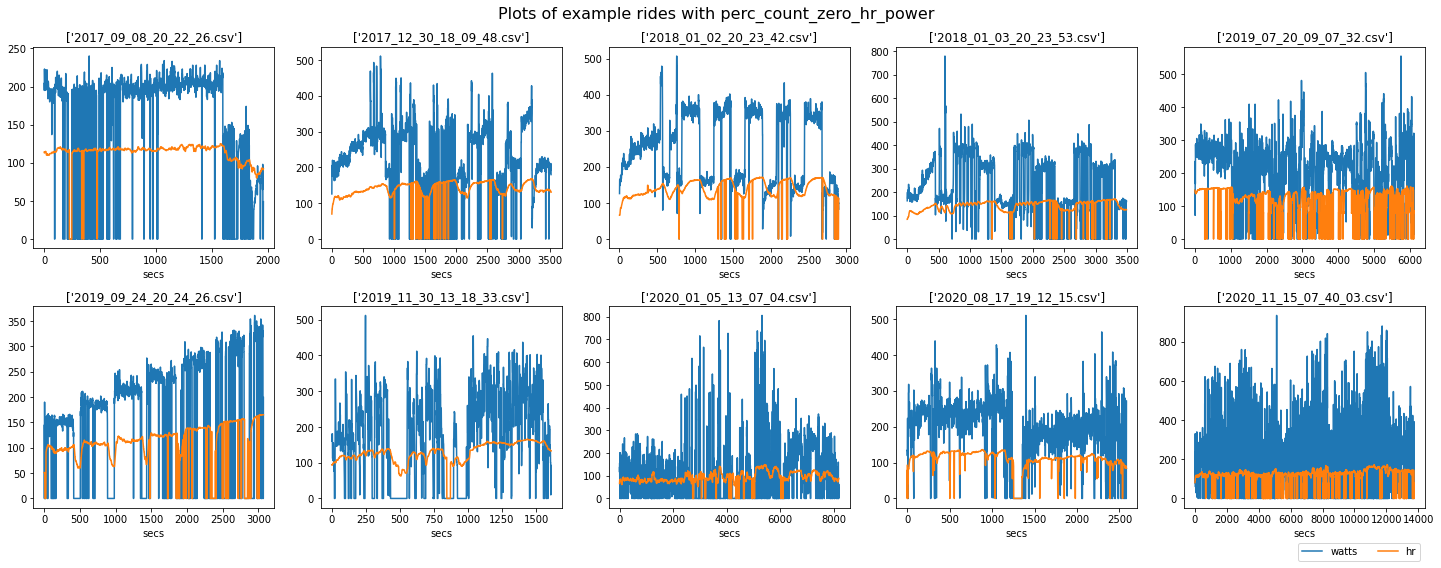

In [73]:
# invoke function
graph_ride_anomalies(df_raw, df_stats, 10, 'perc_count_zero_hr_power', 2, 5)

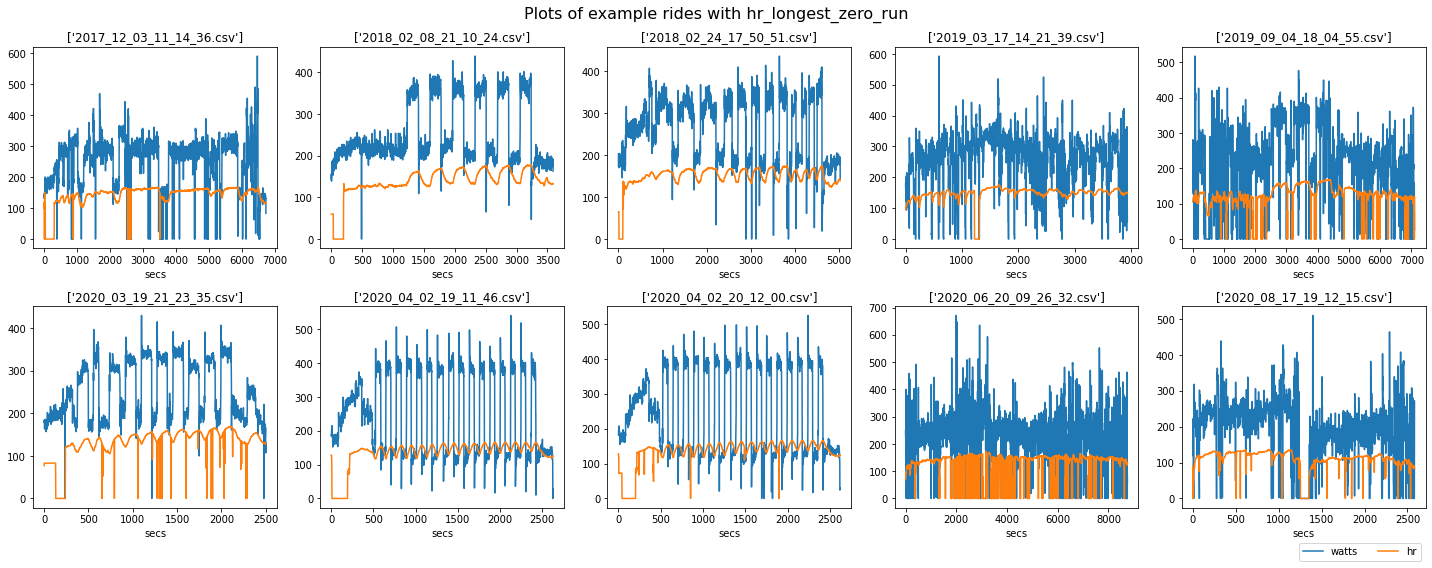

In [74]:
# invoke function
graph_ride_anomalies(df_raw, df_stats, 10, 'hr_longest_zero_run', 2, 5)

**Observations**

We sometimes have longer blocks with no power nor heart rate. We remove those specific blocks (with periods longer than 4 seconds)

## Iteration 5

In [75]:
# remove bloks with no HR data nor power data for at least 4 seconds. After that we do the procedure for HR only
# procedure for cleaning the long power with zeros
# df_raw_1_3 = df_raw_1_3.reset_index(drop=True)

s = df_raw.loc[(df_raw.watts==0) & (df_raw.hr==0)].index.to_series()
start = s[s.diff(1) != 1].reset_index(drop=True)
end = s[s.diff(-1) != -1].reset_index(drop=True)

zero_power_start_end = pd.DataFrame({'start': start, 'end': end}, columns=['start', 'end'])
zero_power_start_end['length_period_zero_hr_watts'] = zero_power_start_end['end'] - zero_power_start_end['start']
zero_power_start_end = zero_power_start_end.loc[zero_power_start_end['length_period_zero_hr_watts']>1]
zero_power_start_end['start_new'] = zero_power_start_end['start'] + 1
zero_power_start_end['end_new'] = zero_power_start_end['end'] - 1

records = zero_power_start_end[['start_new','end_new']].to_records(index=False)
result = list(records)

lijst_tot = []
for pair in result:
    a, b = pair
    lijstje = list(range(a,b))
    lijst_tot.append(lijstje)
    
flat_list = [item for sublist in lijst_tot for item in sublist]

print('Amount of records we had', df_raw.shape[0])

df_raw = df_raw[~df_raw.index.isin(flat_list)]
df_raw = df_raw.reset_index(drop=True)

print('Now we have {0:.1f} records'.format(df_raw.shape[0]))

Amount of records we had 4181325
Now we have 4180385.0 records


## Iteration 6

In [76]:
# remove bloks with no HR data 

s = df_raw.loc[(df_raw.hr==0)].index.to_series()
start = s[s.diff(1) != 1].reset_index(drop=True)
end = s[s.diff(-1) != -1].reset_index(drop=True)

zero_hr_start_end = pd.DataFrame({'start': start, 'end': end}, columns=['start', 'end'])
zero_hr_start_end['length_period_zero_hr'] = zero_hr_start_end['end'] - zero_hr_start_end['start']
zero_hr_start_end = zero_hr_start_end.loc[zero_hr_start_end['length_period_zero_hr']>1]
zero_hr_start_end['start_new'] = zero_hr_start_end['start'] + 1
zero_hr_start_end['end_new'] = zero_hr_start_end['end'] - 1

records = zero_hr_start_end[['start_new','end_new']].to_records(index=False)
result = list(records)

lijst_tot = []
for pair in result:
    a, b = pair
    lijstje = list(range(a,b))
    lijst_tot.append(lijstje)
    
flat_list = [item for sublist in lijst_tot for item in sublist]

print('Amount of records we had', df_raw.shape[0])

df_raw = df_raw[~df_raw.index.isin(flat_list)]
df_raw = df_raw.reset_index(drop=True)

print('Now we have ',df_raw.shape[0],'records')

Amount of records we had 4180385
Now we have  4172134 records


In [77]:
# first add indicator hr_power is zero (complete dropouts)

df_raw['secs'] = df_raw.groupby('filename').cumcount()+1

df_raw['hr_power_zero'] = np.where((df_raw['hr']==0) & (df_raw['watts'] == 0) , 0,1)
df_raw['hr_power_ratio'] = np.round(df_raw['watts']/df_raw['hr']*100, 2)

# add some indicators for consecutive similar values for variables that might be used for modelling further
df_raw['consecutive_hr_similar_values'] = df_raw.hr.groupby([df_raw.filename, df_raw.hr.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_power_similar_values'] = df_raw.watts.groupby([df_raw.filename, df_raw.watts.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_cad_similar_values'] = df_raw.cad.groupby([df_raw.filename, df_raw.cad.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_hr_power_ratio_similar_values'] = df_raw.hr_power_ratio.groupby([df_raw.filename, df_raw.hr_power_ratio.diff().ne(0).cumsum()]).transform('size')

# apply the function for ride statistics
df_stats = ride_stats_calculation(df_raw)
df_stats.head(5)

filename  count_records     mean_hr   mean_cad  mean_power  \
0  2017_01_02_20_00_03.csv           3653  151.170819  84.703258  252.539283   
1  2017_01_03_20_07_36.csv           3065  146.652202  82.800653  255.368352   
2  2017_01_07_19_57_46.csv           5286  142.734960  86.547295  210.615210   
3  2017_01_08_18_02_53.csv           3514  142.485771  75.098463  222.432555   
4  2017_01_10_19_48_18.csv           3613  133.324661  83.260172  197.011901   

   mean_temp   mean_alt  mean_slope  min_hr  max_hr  min_cad  max_cad  \
0   7.175198  -9.970600    0.008560      50     175        0      103   
1   8.397716  33.758238    0.051991     100     170        0       97   
2   6.706773   0.929550   -0.007759      49     167        0      110   
3   9.905521  15.694878    0.014576      59     168        0       98   
4  10.152505   2.161915   -0.003398      80     174        0      103   

   min_power  max_power  min_temp  max_temp  min_alt  max_alt  min_slope  \
0          0        375         6        14    -11.6     -8.6  -1.835940   
1          0        363         7        16     29.2     37.6  -1.407380   
2          0        433         5        15     -0.4      1.8  -2.824860   
3          0        380         9        17     14.0     17.4  -0.932401   
4          0        369         9        16      0.8      3.8  -0.611377   

   max_slope     std_hr     std_power  cv_hr  cv_power  count_zero_hr  \
0   1.384620  20.121043   7774.461011   0.13     30.79              0   
1   1.398600  16.084239   6477.967732   0.11     25.37              0   
2   2.869440  16.010023   8152.240556   0.11     38.71              0   
3   0.943315  17.973902  11690.618991   0.13     52.56              0   
4   7.299270  20.874355   9619.128042   0.16     48.83              0   

   count_zero_cad  count_zero_power  perc_count_zero_hr  perc_count_zero_cad  \
0              62               122                 0.0                  2.0   
1              38                92                 0.0                  1.0   
2             367               654                 0.0                  7.0   
3             281               491                 0.0                  8.0   
4             160               303                 0.0                  4.0   

   perc_count_zero_power  count_zero_hr_power  perc_count_zero_hr_power  \
0                    3.0                    0                       0.0   
1                    3.0                    0                       0.0   
2                   12.0                    0                       0.0   
3                   14.0                    0                       0.0   
4                    8.0                    0                       0.0   

   hr_longest_zero_run  cad_longest_zero_run  power_longest_zero_run  \
0                    0                     6                       7   
1                    0                     6                       7   
2                    0                    11                      14   
3                    0                    12                      16   
4                    0                    20                      21   

   perc_hr_longest_zero_run  perc_cad_longest_zero_run  \
0                       0.0                        0.0   
1                       0.0                        0.0   
2                       0.0                        0.0   
3                       0.0                        0.0   
4                       0.0                        1.0   

   perc_power_longest_zero_run  count_power_extremes  count_cad_extremes  \
0                          0.0                     0                   0   
1                          0.0                     0                   0   
2                          0.0                     0                   0   
3                          0.0                     0                   0   
4                          1.0                     0                   0   

   perc_power_extremes  perc_ca

In [78]:
# inspect top 5 rides with longest hr zero run. ''Now solved''
df_stats[['filename','count_records','count_zero_hr','hr_longest_zero_run','perc_count_zero_hr','count_zero_power','perc_count_zero_power']].sort_values(by=['hr_longest_zero_run'], ascending = False).head(6)

filename  count_records  count_zero_hr  \
610  2020_02_10_20_15_34.csv           3497             58   
209  2018_02_08_21_10_24.csv           3429              3   
233  2018_03_24_11_47_13.csv           5808              3   
602  2020_01_15_19_59_00.csv           5220             29   
229  2018_03_20_21_04_43.csv           2612             27   
609  2020_02_09_17_33_26.csv           3088             14   

     hr_longest_zero_run  perc_count_zero_hr  count_zero_power  \
610                    3                 2.0                 6   
209                    3                 0.0                 3   
233                    3                 0.0               146   
602                    3                 1.0                61   
229                    3                 1.0                14   
609                    3                 0.0                 4   

     perc_count_zero_power  
610                    0.0  
209                    0.0  
233                    3.0  
602                    1.0  
229                    1.0  
609                    0.0

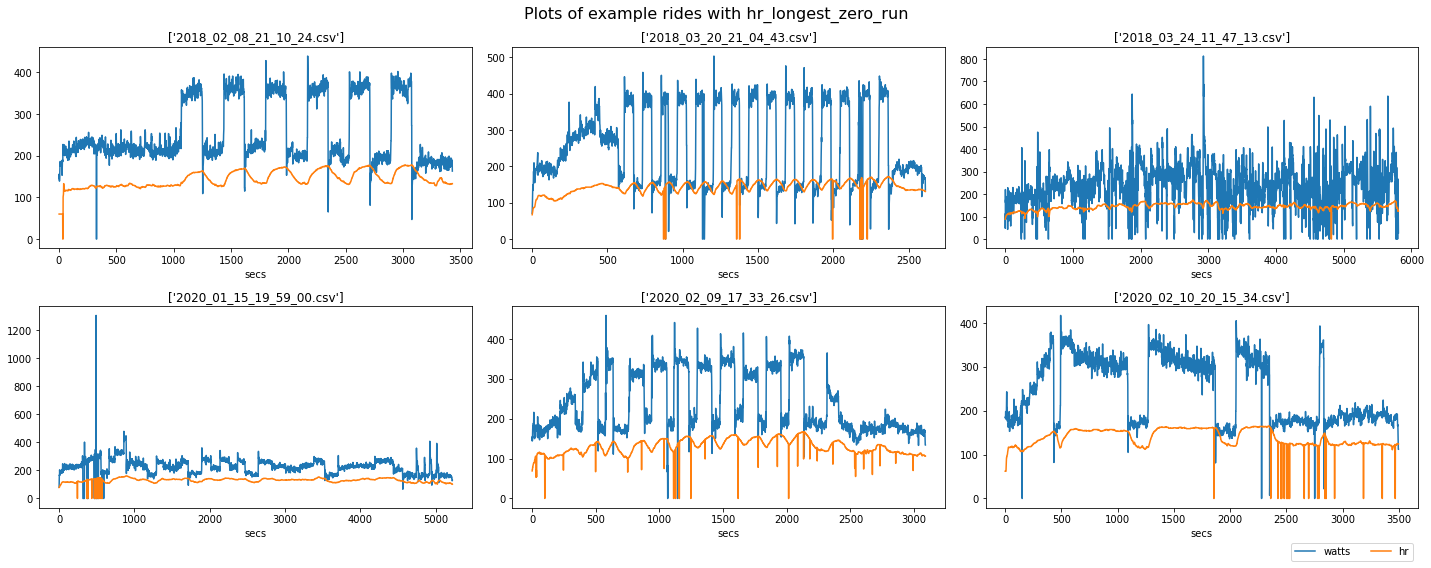

In [80]:
# invoke function
graph_ride_anomalies(df_raw, df_stats, 6, 'hr_longest_zero_run', 2, 3)

The problem is not completely solved but it is better than before. We now still have drops

In [81]:
# inspect top 5 rides with power data lots of zero heart rate counts
df_stats[['filename','count_records','count_zero_hr','perc_count_zero_hr','count_zero_power','perc_count_zero_power']].sort_values(by=['count_zero_hr'], ascending = False).head(6)

filename  count_records  count_zero_hr  \
758  2020_11_15_07_40_03.csv          12544            489   
672  2020_06_20_09_26_32.csv           7333            350   
741  2020_10_14_14_02_07.csv           8873            340   
508  2019_07_20_09_07_32.csv           6057            237   
481  2019_05_29_14_02_46.csv           5660            182   
656  2020_05_12_16_13_45.csv           5121            143   

     perc_count_zero_hr  count_zero_power  perc_count_zero_power  
758                 4.0              1888                   15.0  
672                 5.0               407                    6.0  
741                 4.0               299                    3.0  
508                 4.0               751                   12.0  
481                 3.0               321                    6.0  
656                 3.0                 2                    0.0

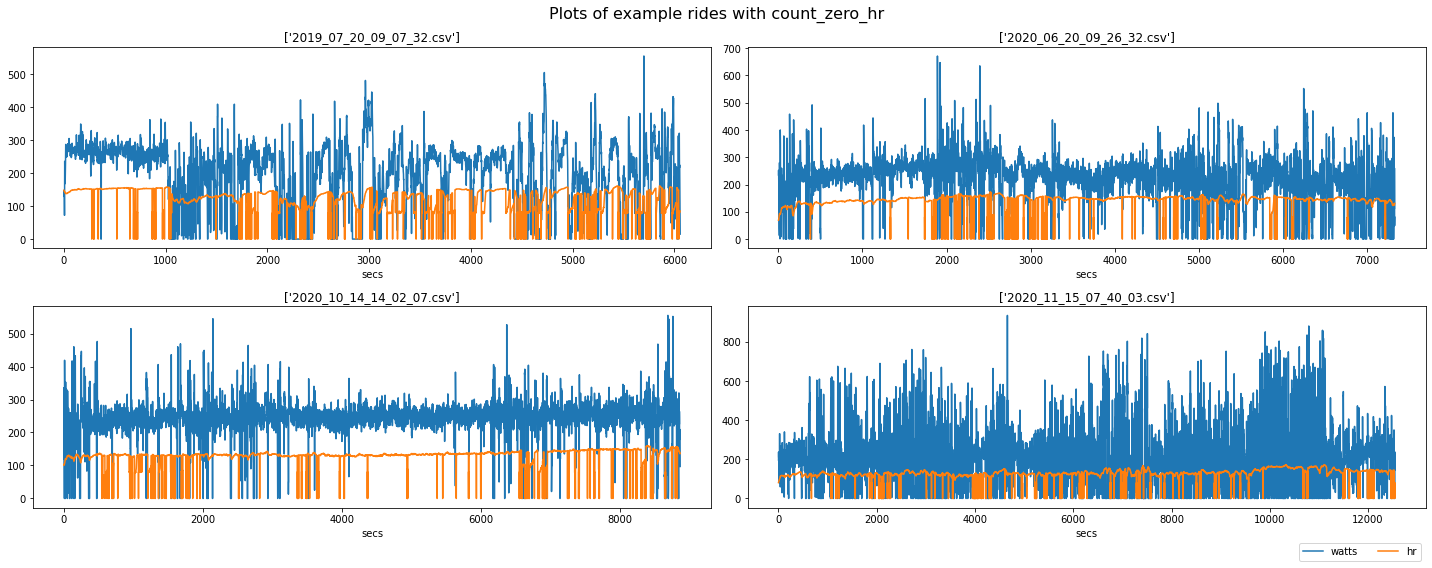

In [82]:
# invoke function
graph_ride_anomalies(df_raw, df_stats, 4, 'count_zero_hr', 2, 2)

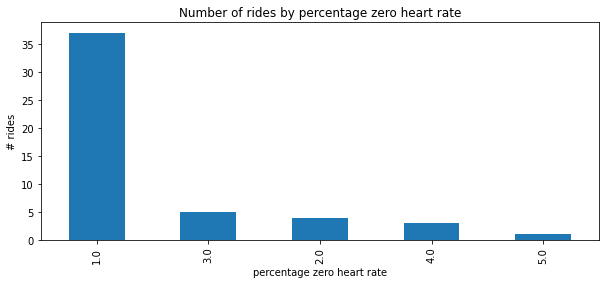

In [89]:
# Plot of 
df_stats.perc_count_zero_hr.value_counts()[1:].plot(kind='bar', figsize=(10,4))
plt.title('Number of rides by percentage zero heart rate')
plt.xlabel('percentage zero heart rate')
plt.ylabel('# rides');

**Observations** 

Apart from zero heart rate we also observe dropouts which don't go to zero. This is also something we should account for next to the data which goes to zero

In [92]:
# inspect top 5 rides with power data lots of zero hr counts
df_stats[['filename','count_records','count_zero_hr','perc_count_zero_hr','count_zero_power','perc_count_zero_power']].sort_values(by=['perc_count_zero_hr'], ascending = False).head(10)

filename  count_records  count_zero_hr  \
672  2020_06_20_09_26_32.csv           7333            350   
508  2019_07_20_09_07_32.csv           6057            237   
741  2020_10_14_14_02_07.csv           8873            340   
758  2020_11_15_07_40_03.csv          12544            489   
481  2019_05_29_14_02_46.csv           5660            182   
180  2017_12_06_15_55_31.csv           1585             53   
366  2018_11_06_20_34_28.csv           2325             77   
538  2019_09_24_20_24_26.csv           2844             72   
656  2020_05_12_16_13_45.csv           5121            143   
192  2018_01_02_20_23_42.csv           2788             56   

     perc_count_zero_hr  count_zero_power  perc_count_zero_power  
672                 5.0               407                    6.0  
508                 4.0               751                   12.0  
741                 4.0               299                    3.0  
758                 4.0              1888                   15.0  
481                 3.0               321                    6.0  
180                 3.0                20                    1.0  
366                 3.0                47                    2.0  
538                 3.0              1051                   37.0  
656                 3.0                 2                    0.0  
192                 2.0                35                    1.0

In [94]:
# inspect top 5 rides with power data lots of zero hr counts
df_stats[['filename','count_records','count_zero_hr','perc_count_zero_hr','count_zero_power','perc_count_zero_power']].sort_values(by=['perc_count_zero_power'], ascending = False).head(10)

filename  count_records  count_zero_hr  \
550  2019_10_19_10_03_14.csv           1369              3   
689  2020_07_20_15_19_41.csv           2525              0   
574  2019_12_01_10_05_50.csv           2075              5   
582  2019_12_22_10_30_23.csv           1180              0   
598  2020_01_11_09_16_09.csv            942              0   
403  2019_01_11_13_18_23.csv           4487              0   
593  2020_01_05_13_07_04.csv           7949             56   
376  2018_11_22_18_55_10.csv           1940              0   
402  2019_01_10_15_00_39.csv           3656              0   
592  2020_01_04_11_28_28.csv           2701              0   

     perc_count_zero_hr  count_zero_power  perc_count_zero_power  
550                 0.0               728                   53.0  
689                 0.0              1343                   53.0  
574                 0.0              1087                   52.0  
582                 0.0               571                   48.0  
598                 0.0               421                   45.0  
403                 0.0              1992                   44.0  
593                 1.0              3526                   44.0  
376                 0.0               826                   43.0  
402                 0.0              1487                   41.0  
592                 0.0              1105                   41.0

## Iteration 7

In [98]:
# We decide to set a bar that if a ride has more than 2% of missing hr values that we delete this data

threshold_perc_zero_hr = 3

#remove those files and make new df
print('We had ',df_stats.shape[0],'ride files')
df_stats = df_stats.loc[(df_stats.perc_count_zero_hr<threshold_perc_zero_hr)].reset_index(drop = True);
print('Now we have ',df_stats.shape[0],'ride files')

print('We had ' ,df_raw.shape[0],'records')
cond = df_raw['filename'].isin(df_stats.filename)
df_raw = df_raw.loc[df_raw[cond==True].index]
print('Now we have ',df_raw.shape[0],'records')
# drop files in raw data
df_raw = df_raw.reset_index(drop=True)

We had  783 ride files
Now we have  774 ride files
We had  4172134 records
Now we have  4119792 records


In [99]:
# inspect top 5 rides with power data lots consequtive similar values
df_stats[['filename','count_records','perc_consecutive_hr_similar_values','consecutive_hr_similar_values','count_zero_hr','perc_count_zero_hr','count_zero_power','perc_count_zero_power']].sort_values(by=['consecutive_hr_similar_values'], ascending = False).head(6)

filename  count_records  \
68   2017_05_20_18_20_36.csv           3238   
81   2017_06_03_12_30_33.csv           5133   
86   2017_06_11_14_34_02.csv           5113   
432  2019_03_10_11_27_53.csv          12317   
273  2018_05_26_09_29_43.csv           7904   
311  2018_07_25_08_56_07.csv           2572   

     perc_consecutive_hr_similar_values  consecutive_hr_similar_values  \
68                                  8.0                            263   
81                                  5.0                            236   
86                                  4.0                            212   
432                                 1.0                            177   
273                                 2.0                            163   
311                                 6.0                            163   

     count_zero_hr  perc_count_zero_hr  count_zero_power  \
68               0                 0.0                 6   
81               3                 0.0               617   
86               3                 0.0                79   
432              9                 0.0               586   
273             12                 0.0               744   
311              0                 0.0               319   

     perc_count_zero_power  
68                     0.0  
81                    12.0  
86                     2.0  
432                    5.0  
273                    9.0  
311                   12.0

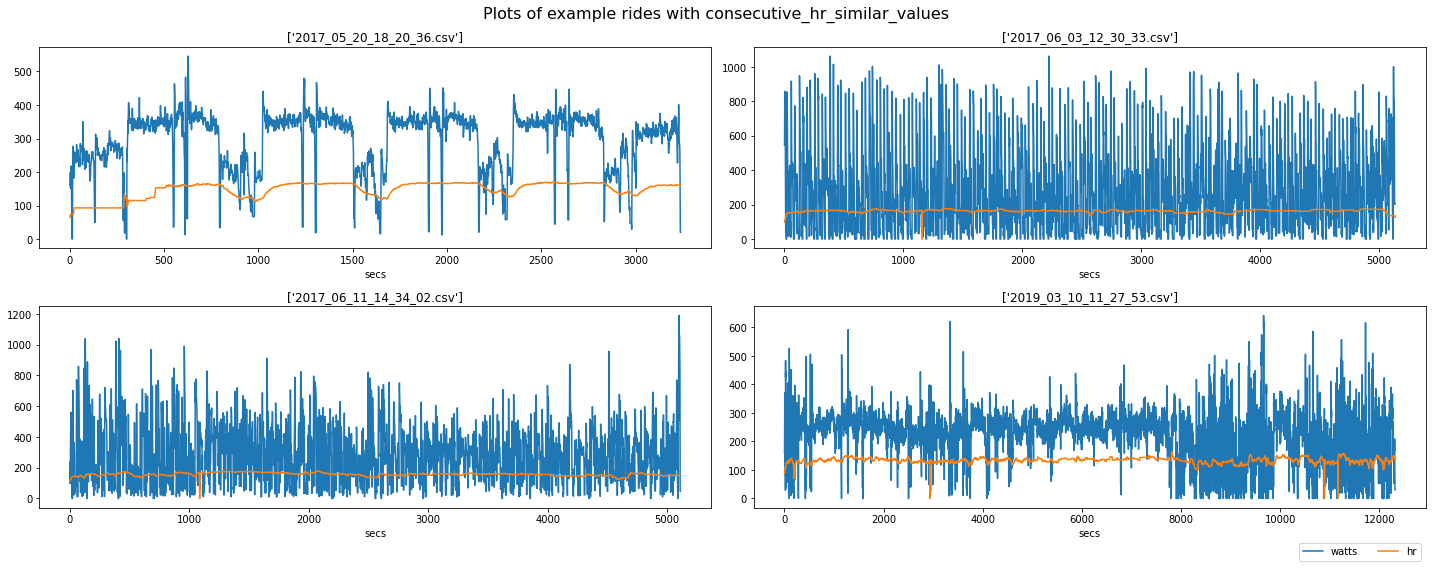

In [100]:
# invoke function
graph_ride_anomalies(df_raw, df_stats, 4, 'consecutive_hr_similar_values', 2, 2)

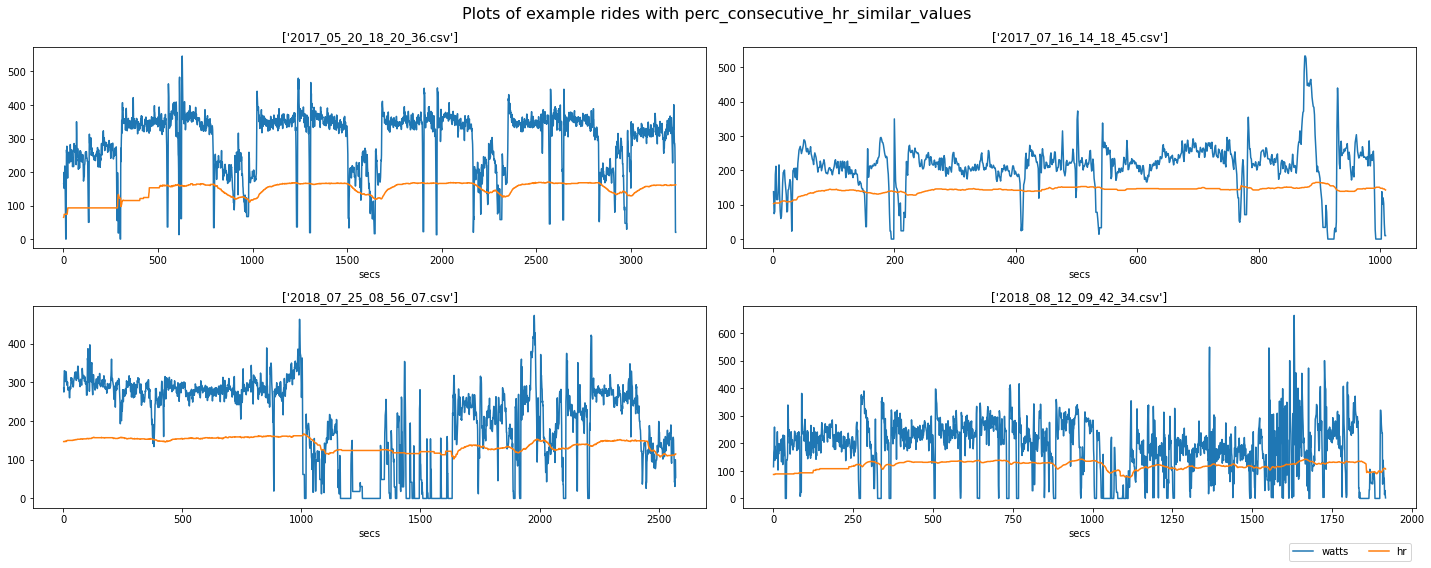

In [101]:
# invoke function
graph_ride_anomalies(df_raw, df_stats, 4, 'perc_consecutive_hr_similar_values', 2, 2)

In [102]:
# inspect top 5 rides with power data lots of zero heart rate counts
df_stats[['filename','count_records','perc_consecutive_hr_similar_values','consecutive_hr_similar_values','count_zero_hr','perc_count_zero_hr','count_zero_power','perc_count_zero_power']].sort_values(by=['perc_consecutive_hr_similar_values'], ascending = False).head(10)

filename  count_records  \
68   2017_05_20_18_20_36.csv           3238   
106  2017_07_16_14_18_45.csv           1009   
311  2018_07_25_08_56_07.csv           2572   
320  2018_08_12_09_42_34.csv           1917   
81   2017_06_03_12_30_33.csv           5133   
624  2020_03_19_21_23_35.csv           2395   
569  2019_12_01_10_05_50.csv           2075   
425  2019_02_26_20_29_42.csv           3971   
362  2018_10_31_15_52_51.csv            210   
245  2018_04_13_15_14_20.csv           2838   

     perc_consecutive_hr_similar_values  consecutive_hr_similar_values  \
68                                  8.0                            263   
106                                 6.0                             63   
311                                 6.0                            163   
320                                 5.0                             91   
81                                  5.0                            236   
624                                 5.0                            129   
569                                 4.0                             82   
425                                 4.0                            148   
362                                 4.0                              9   
245                                 4.0                            116   

     count_zero_hr  perc_count_zero_hr  count_zero_power  \
68               0                 0.0                 6   
106              0                 0.0                26   
311              0                 0.0               319   
320              0                 0.0               168   
81               3                 0.0               617   
624             23                 1.0                 4   
569              5                 0.0              1087   
425              0                 0.0                41   
362              0                 0.0                42   
245              0                 0.0                94   

     perc_count_zero_power  
68                     0.0  
106                    3.0  
311                   12.0  
320                    9.0  
81                    12.0  
624                    0.0  
569                   52.0  
425                    1.0  
362                   20.0  
245                    3.0

**Observations**
* We see flatliners of heart rate which sometimes do occur simultaneously with flatliners in power output and sometimes not
* It seems in general it are some more shorter rides. Based on this we will remove rides with less than 900 records which have heart rate flatliners with more than 3% long

## Iteration 8

In [105]:
# remove the files

# thresholds
theshold_perc_conseq_similar_hr = 3
threshold_count_records = 900

# stats file
print('We had ',df_stats.shape[0],'ride files')
df_files_drop = df_stats.loc[(df_stats.perc_consecutive_hr_similar_values>theshold_perc_conseq_similar_hr) & (df_stats.count_records<threshold_count_records)]
df_stats = df_stats.loc[~((df_stats.perc_consecutive_hr_similar_values>theshold_perc_conseq_similar_hr) & (df_stats.count_records<threshold_count_records))].reset_index(drop = True)
print('We have ',df_stats.shape[0],'files left');

# raw data file
print('We had ' ,df_raw.shape[0],'records')
cond = df_raw['filename'].isin(df_files_drop.filename)
df_raw = df_raw.drop(df_raw[cond==True].index)
df_raw = df_raw.reset_index(drop=True)
print('Now we have ',df_raw.shape[0],'records')

We had  774 ride files
We have  773 files left
We had  4119792 records
Now we have  4119582 records


In [107]:
# inspect top 10 rides with power data flatliner where power not equal to zero
df_stats[['filename','count_records','consecutive_power_similar_values','consecutive_hr_similar_values','count_zero_hr','perc_count_zero_hr','perc_consecutive_hr_similar_values','perc_count_zero_power']].loc[(df_stats.consecutive_power_similar_values)!=(df_stats.power_longest_zero_run)].sort_values(by=['consecutive_power_similar_values'], ascending = False).head(10)

filename  count_records  consecutive_power_similar_values  \
35   2017_03_12_07_19_58.csv          17448                               114   
44   2017_04_02_08_47_34.csv          15592                               103   
170  2017_11_15_18_10_04.csv           3119                                30   
169  2017_11_13_18_28_38.csv           3438                                29   
173  2017_11_21_19_28_23.csv           3711                                29   
40   2017_03_26_12_48_50.csv           8865                                28   
46   2017_04_07_14_47_09.csv           7294                                22   
616  2020_03_04_15_25_59.csv           7819                                20   
449  2019_04_09_19_39_35.csv           4648                                20   
445  2019_04_01_18_58_09.csv           5503                                19   

     consecutive_hr_similar_values  count_zero_hr  perc_count_zero_hr  \
35                              49              5                 0.0   
44                              29              4                 0.0   
170                             53             10                 0.0   
169                             37              4                 0.0   
173                             38              0                 0.0   
40                              69              0                 0.0   
46                              36              0                 0.0   
616                             58              0                 0.0   
449                             28              0                 0.0   
445                             38              0                 0.0   

     perc_consecutive_hr_similar_values  perc_count_zero_power  
35                                  0.0                    0.0  
44                                  0.0                    0.0  
170                                 2.0                    1.0  
169                                 1.0                    2.0  
173                                 1.0                    2.0  
40                                  1.0                    0.0  
46                                  0.0                    0.0  
616                                 1.0                    3.0  
449                                 1.0                    3.0  
445                                 1.0                    1.0

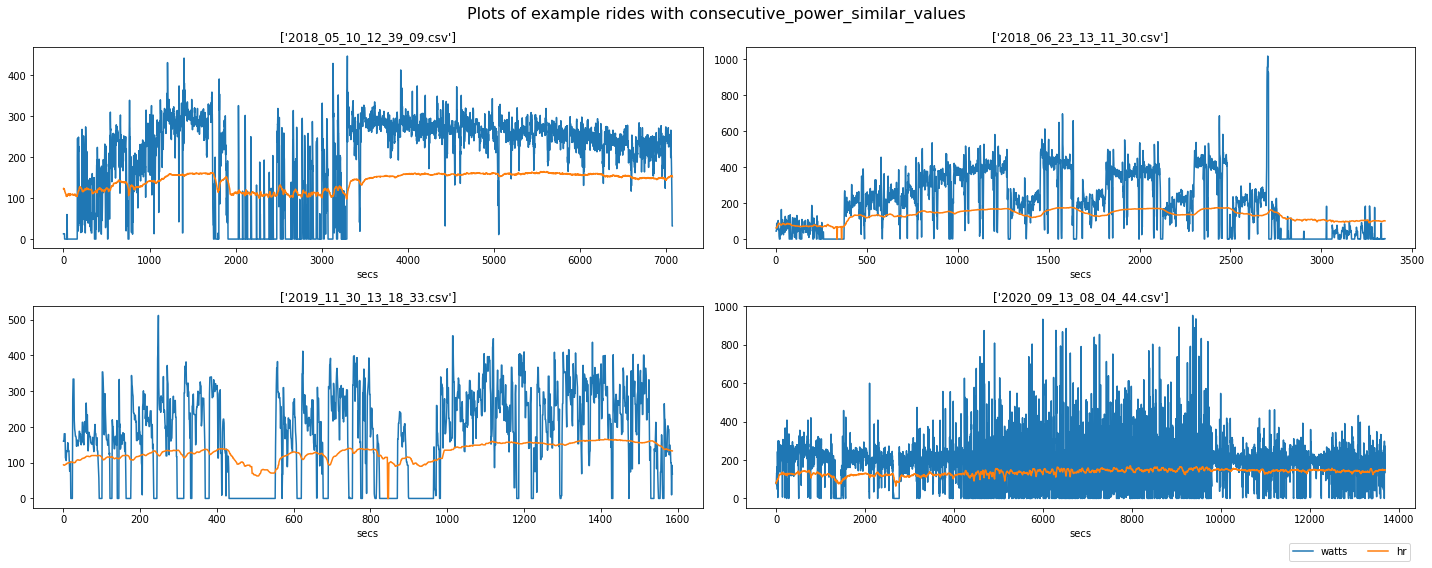

In [108]:
# invoke function
graph_ride_anomalies(df_raw, df_stats, 4, 'consecutive_power_similar_values', 2, 2)

In [79]:
# inspect top 5 rides with hr data flatliner where heart rate not equal to zero
df_stats[['filename','count_records','perc_consecutive_hr_similar_values','consecutive_hr_similar_values','count_zero_hr','perc_count_zero_hr','count_zero_power','perc_count_zero_power']].sort_values(by=['perc_consecutive_hr_similar_values'], ascending = False).head(10)

filename  count_records  \
68   2017_05_20_18_20_36.csv           3238   
106  2017_07_16_14_18_45.csv           1009   
311  2018_07_25_08_56_07.csv           2572   
623  2020_03_19_21_23_35.csv           2395   
320  2018_08_12_09_42_34.csv           1917   
81   2017_06_03_12_30_33.csv           5133   
245  2018_04_13_15_14_20.csv           2838   
424  2019_02_26_20_29_42.csv           3971   
86   2017_06_11_14_34_02.csv           5113   
568  2019_12_01_10_05_50.csv           2075   

     perc_consecutive_hr_similar_values  consecutive_hr_similar_values  \
68                                  8.0                            263   
106                                 6.0                             63   
311                                 6.0                            163   
623                                 5.0                            129   
320                                 5.0                             91   
81                                  5.0                            236   
245                                 4.0                            116   
424                                 4.0                            148   
86                                  4.0                            212   
568                                 4.0                             82   

     count_zero_hr  perc_count_zero_hr  count_zero_power  \
68               0                 0.0                 6   
106              0                 0.0                26   
311              0                 0.0               319   
623             23                 1.0                 4   
320              0                 0.0               168   
81               3                 0.0               617   
245              0                 0.0                94   
424              0                 0.0                41   
86               3                 0.0                79   
568              5                 0.0              1087   

     perc_count_zero_power  
68                     0.0  
106                    3.0  
311                   12.0  
623                    0.0  
320                    9.0  
81                    12.0  
245                    3.0  
424                    1.0  
86                     2.0  
568                   52.0

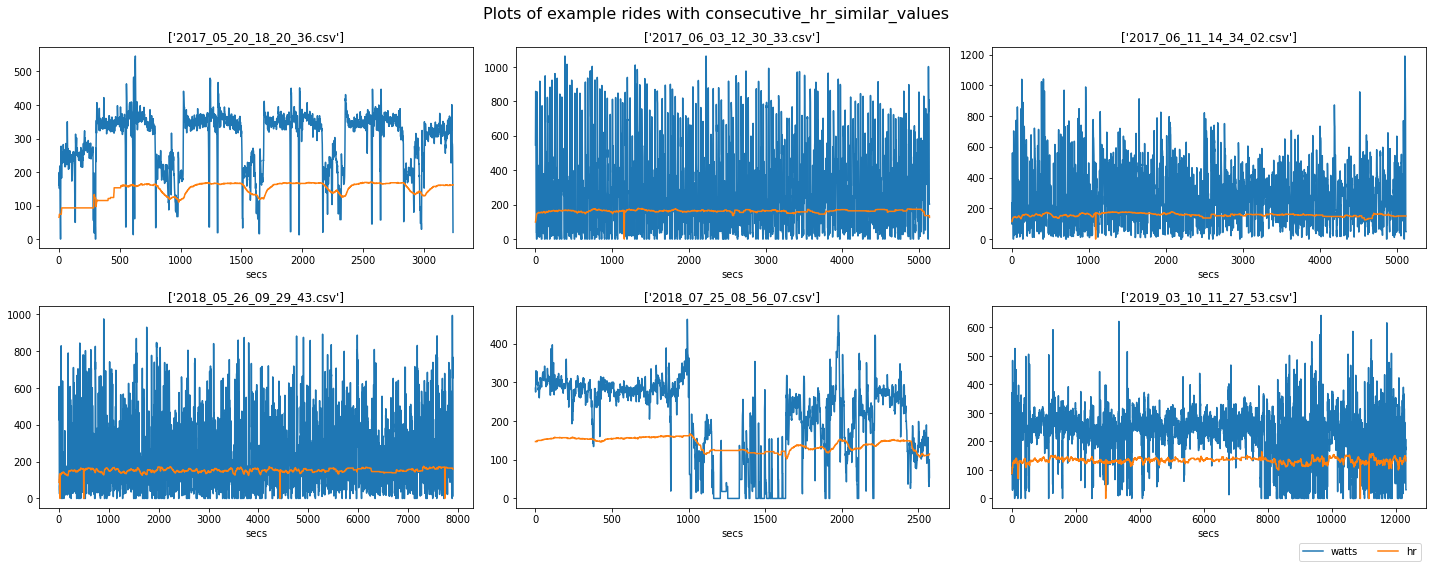

In [109]:
# invoke function
graph_ride_anomalies(df_raw, df_stats, 6, 'consecutive_hr_similar_values', 2, 3)

## Iteration 9

In [110]:
# first delete the heart rate flatliners. We are using a theshold of 50. After that the signal is picked up again.
start_time = datetime.now()

# set threshold
theshold_conseq_similar_hr = 50

print('We had ' ,df_raw.shape[0],'records')

df_raw_1 = pd.DataFrame()

for i in df_raw.filename.unique():
    df_init = df_raw.loc[df_raw.filename==i]
    s = df_init['hr'].diff().ne(0).cumsum()
    small_size = s.groupby(s).transform('size') < theshold_conseq_similar_hr
    #first_rows = ~s.duplicated()
    df_init = df_init[small_size==True]
    df_raw_1 = df_raw_1.append(df_init, ignore_index=True)

print('Now we have ',df_raw_1.shape[0],'records')
print('Time processing', datetime.now()-start_time)

We had  4119582 records
Now we have  4097469 records
Time processing 0:07:33.670002


In [112]:
# free memory
del X, df_files_drop,df_init,df_statss,zero_hr_start_end, zero_power_start_end
gc.collect()

30757

In [117]:
df_raw = df_raw_1

# free memory
del df_raw_1
gc.collect()

# first add indicator hr_power is zero (complete dropouts)

df_raw['secs'] = df_raw.groupby('filename').cumcount()+1

df_raw['hr_power_zero'] = np.where((df_raw['hr']==0) & (df_raw['watts'] == 0) , 0,1)
df_raw['hr_power_ratio'] = np.round(df_raw['watts']/df_raw['hr']*100, 2)

# add some indicators for consecutive similar values for variables that might be used for modelling further
df_raw['consecutive_hr_similar_values'] = df_raw.hr.groupby([df_raw.filename, df_raw.hr.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_power_similar_values'] = df_raw.watts.groupby([df_raw.filename, df_raw.watts.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_cad_similar_values'] = df_raw.cad.groupby([df_raw.filename, df_raw.cad.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_hr_power_ratio_similar_values'] = df_raw.hr_power_ratio.groupby([df_raw.filename, df_raw.hr_power_ratio.diff().ne(0).cumsum()]).transform('size')

# apply the function for ride statistics
df_stats = ride_stats_calculation(df_raw)
df_stats.head(5)

filename  count_records     mean_hr   mean_cad  mean_power  \
0  2017_01_02_20_00_03.csv           3653  151.170819  84.703258  252.539283   
1  2017_01_03_20_07_36.csv           3065  146.652202  82.800653  255.368352   
2  2017_01_07_19_57_46.csv           5286  142.734960  86.547295  210.615210   
3  2017_01_08_18_02_53.csv           3310  141.571601  75.634139  222.556193   
4  2017_01_10_19_48_18.csv           3562  132.856822  83.324537  195.807692   

   mean_temp   mean_alt  mean_slope  min_hr  max_hr  min_cad  max_cad  \
0   7.175198  -9.970600    0.008560      50     175        0      103   
1   8.397716  33.758238    0.051991     100     170        0       97   
2   6.706773   0.929550   -0.007759      49     167        0      110   
3   9.961329  15.660060    0.015757      59     168        0       98   
4  10.169006   2.157777   -0.003963      80     174        0      103   

   min_power  max_power  min_temp  max_temp  min_alt  max_alt  min_slope  \
0          0        375         6        14    -11.6     -8.6  -1.835940   
1          0        363         7        16     29.2     37.6  -1.407380   
2          0        433         5        15     -0.4      1.8  -2.824860   
3          0        380         9        17     14.0     17.4  -0.932401   
4          0        369         9        16      0.8      3.8  -0.611377   

   max_slope     std_hr     std_power  cv_hr  cv_power  count_zero_hr  \
0   1.384620  20.121043   7774.461011   0.13     30.79              0   
1   1.398600  16.084239   6477.967732   0.11     25.37              0   
2   2.869440  16.010023   8152.240556   0.11     38.71              0   
3   0.943315  18.109173  11317.756134   0.13     50.85              0   
4   7.299270  20.651132   9470.928186   0.16     48.37              0   

   count_zero_cad  count_zero_power  perc_count_zero_hr  perc_count_zero_cad  \
0              62               122                 0.0                  2.0   
1              38                92                 0.0                  1.0   
2             367               654                 0.0                  7.0   
3             247               437                 0.0                  7.0   
4             157               296                 0.0                  4.0   

   perc_count_zero_power  count_zero_hr_power  perc_count_zero_hr_power  \
0                    3.0                    0                       0.0   
1                    3.0                    0                       0.0   
2                   12.0                    0                       0.0   
3                   13.0                    0                       0.0   
4                    8.0                    0                       0.0   

   hr_longest_zero_run  cad_longest_zero_run  power_longest_zero_run  \
0                    0                     6                       7   
1                    0                     6                       7   
2                    0                    11                      14   
3                    0                    12                      16   
4                    0                    20                      21   

   perc_hr_longest_zero_run  perc_cad_longest_zero_run  \
0                       0.0                        0.0   
1                       0.0                        0.0   
2                       0.0                        0.0   
3                       0.0                        0.0   
4                       0.0                        1.0   

   perc_power_longest_zero_run  count_power_extremes  count_cad_extremes  \
0                          0.0                     0                   0   
1                          0.0                     0                   0   
2                          0.0                     0                   0   
3                          0.0                     0                   0   
4                          1.0                     0                   0   

   perc_power_extremes  perc_ca

In [118]:
# inspect top 10 rides with heart rate data flatliner where heart rate not equal to zero
df_stats[['filename','count_records','perc_consecutive_hr_similar_values','consecutive_hr_similar_values','count_zero_hr','perc_count_zero_hr','hr_longest_zero_run','perc_count_zero_power']].sort_values(by=['hr_longest_zero_run'], ascending = False).head(10)

filename  count_records  \
436  2019_03_17_14_21_39.csv           3854   
170  2017_11_15_18_10_04.csv           3066   
662  2020_06_09_18_51_34.csv           7207   
661  2020_06_08_19_05_49.csv           2609   
288  2018_06_20_14_41_32.csv          10312   
285  2018_06_16_07_51_21.csv          12960   
284  2018_06_14_19_44_11.csv           4811   
147  2017_09_27_18_10_03.csv           4229   
557  2019_11_13_16_45_43.csv           3965   
655  2020_05_23_06_48_21.csv          19815   

     perc_consecutive_hr_similar_values  consecutive_hr_similar_values  \
436                                 1.0                             30   
170                                 1.0                             44   
662                                 0.0                             29   
661                                 1.0                             19   
288                                 0.0                             25   
285                                 0.0                             33   
284                                 1.0                             48   
147                                 1.0                             33   
557                                 1.0                             38   
655                                 0.0                             45   

     count_zero_hr  perc_count_zero_hr  hr_longest_zero_run  \
436              3                 0.0                    3   
170             10                 0.0                    3   
662             14                 0.0                    3   
661             14                 1.0                    3   
288             15                 0.0                    3   
285              6                 0.0                    3   
284             12                 0.0                    3   
147              3                 0.0                    3   
557              9                 0.0                    3   
655             44                 0.0                    3   

     perc_count_zero_power  
436                    3.0  
170                    1.0  
662                    3.0  
661                    0.0  
288                    5.0  
285                    8.0  
284                    5.0  
147                    5.0  
557                    0.0  
655                    5.0

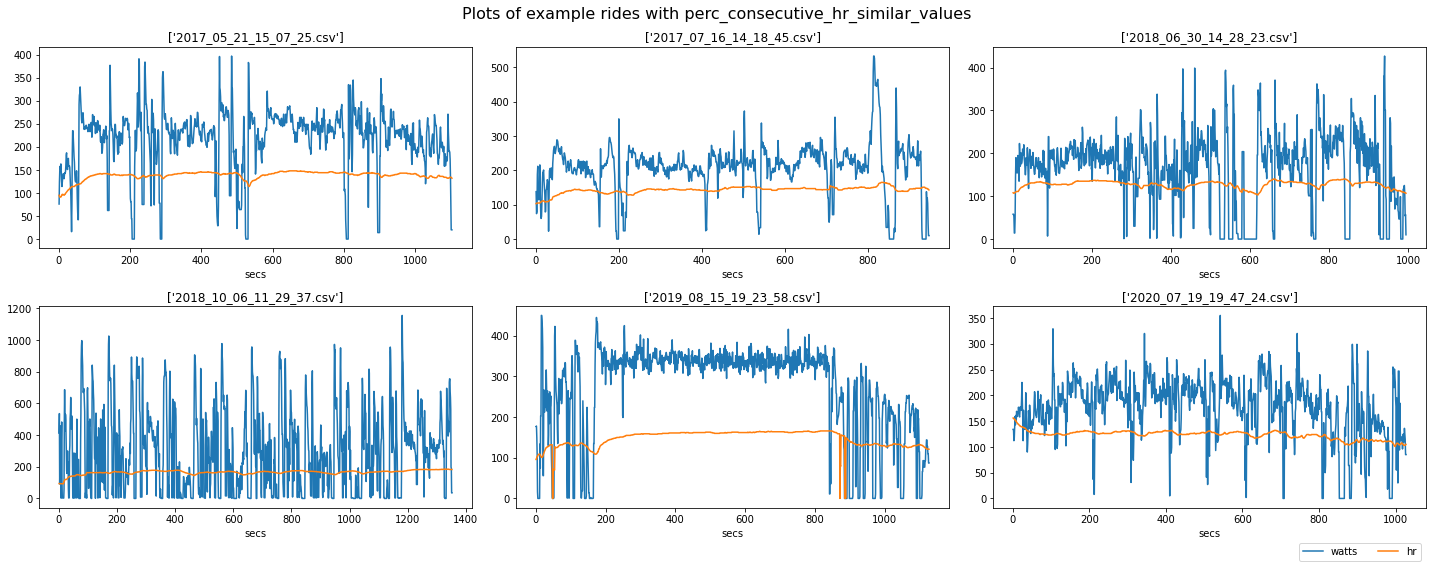

In [119]:
# invoke function
graph_ride_anomalies(df_raw, df_stats, 6, 'perc_consecutive_hr_similar_values', 2, 3)

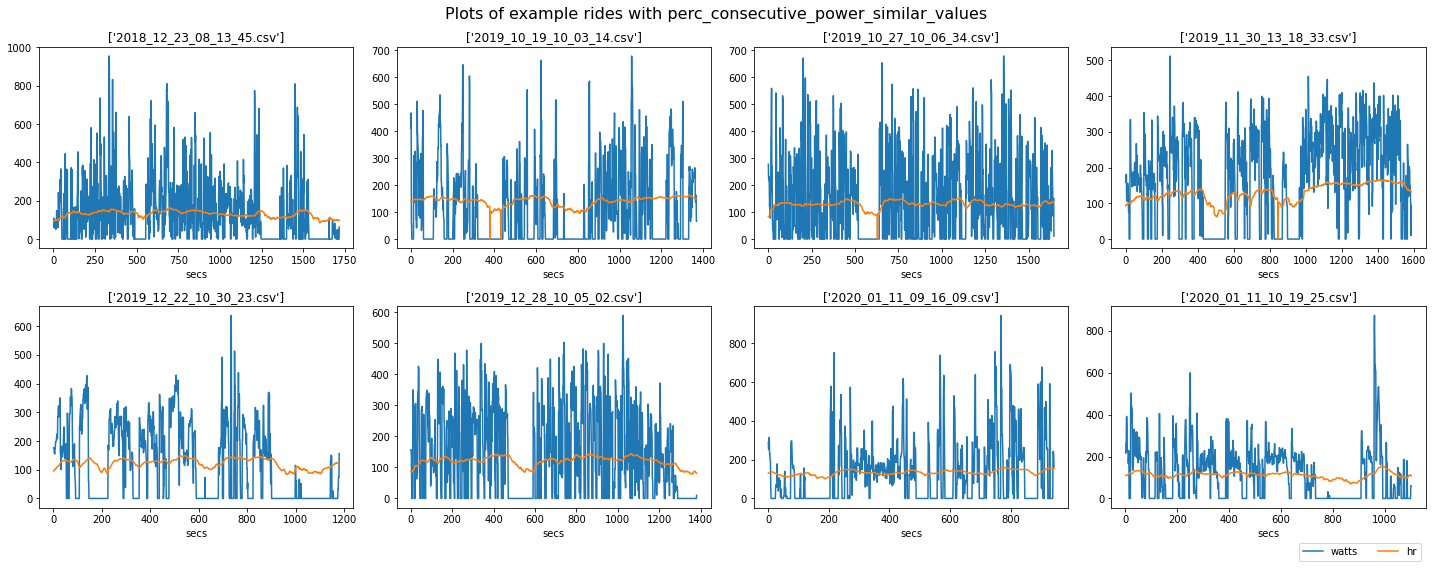

In [121]:
# invoke function
graph_ride_anomalies(df_raw, df_stats, 8, 'perc_consecutive_power_similar_values', 2, 4)

**Observations**

The consequetive longer power flatliners are reduced and seem to relate to no power (watts=0) instead of periods with watt flatliners with watts>0. Lets now look at the zero heart rate to solve these problems along with the sudden heart rate drops which do not go to zero

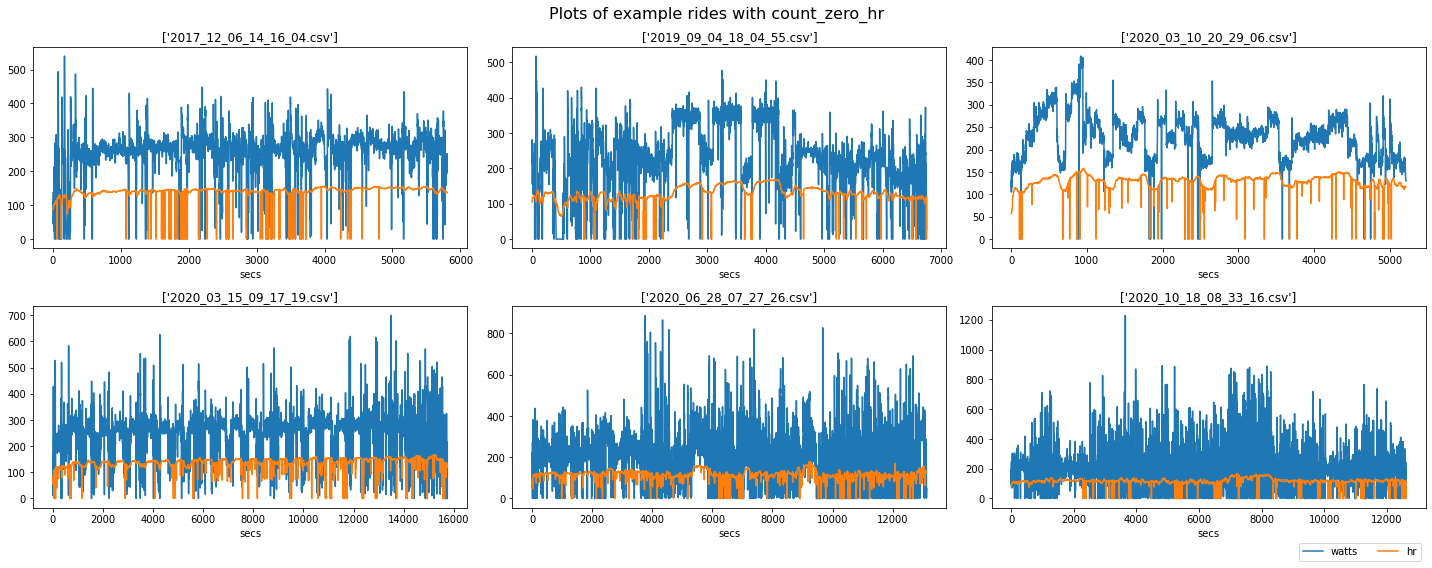

In [122]:
# invoke function
graph_ride_anomalies(df_raw, df_stats, 6, 'count_zero_hr', 2, 3)

In [123]:
# inspect top 10 rides with hr data flatliner where hr not equal to zero
df_stats[['filename','count_records','perc_consecutive_power_similar_values','consecutive_power_similar_values','hr_longest_zero_run','perc_count_zero_hr','count_zero_hr','perc_count_zero_power']].sort_values(by=['perc_count_zero_hr'], ascending = False).head(10)

filename  count_records  \
604  2020_02_10_20_15_34.csv           3497   
191  2018_01_02_20_23_42.csv           2788   
192  2018_01_03_20_23_53.csv           3450   
179  2017_12_06_14_16_04.csv           5808   
669  2020_06_30_18_40_53.csv           5243   
619  2020_03_10_20_29_06.csv           5215   
734  2020_10_18_08_33_16.csv          12610   
733  2020_10_17_14_32_11.csv           3370   
732  2020_10_13_15_31_34.csv           3744   
728  2020_10_07_13_53_47.csv           2161   

     perc_consecutive_power_similar_values  consecutive_power_similar_values  \
604                                    0.0                                 5   
191                                    0.0                                 4   
192                                    1.0                                20   
179                                    0.0                                23   
669                                    0.0                                 5   
619                                    0.0                                 6   
734                                    0.0                                26   
733                                    0.0                                 6   
732                                    0.0                                16   
728                                    2.0                                39   

     hr_longest_zero_run  perc_count_zero_hr  count_zero_hr  \
604                    3                 2.0             58   
191                    3                 2.0             56   
192                    3                 2.0             65   
179                    3                 2.0            140   
669                    3                 1.0             33   
619                    3                 1.0             70   
734                    3                 1.0            110   
733                    2                 1.0             17   
732                    3                 1.0             20   
728                    3                 1.0             13   

     perc_count_zero_power  
604                    0.0  
191                    1.0  
192                   14.0  
179                    4.0  
669                    0.0  
619                    1.0  
734                   14.0  
733                    0.0  
732                    2.0  
728                   18.0

## Iteration 11

In [124]:
# First we will now deal with part of the zero heart rate problem. We will for a max of 1 seconds of zero impute with the last non-heart rate value which was not a heart rate drop
# If it is a heart rate drop we will not impute. For this we first add some lagged differences 

start_time = datetime.now()

# define thresholds
threshold_filling_consecutive_zero_hr = 1 
threshold_difference_fill_zero_hr = 10

# function which defines fillings of zero hr
def fill_zero_hr():
    df_raw['hr_diff_t1'] = df_raw.groupby("filename").hr.diff(1).abs()
    df_raw['hr'] = np.where(((df_raw['hr']==0) & (df_raw['hr'].shift(1)>0) & ((df_raw['hr_diff_t1'])-(df_raw['hr'].shift(1))<threshold_difference_fill_zero_hr)), df_raw['hr'].shift(1), df_raw['hr'])

for _ in range(threshold_filling_consecutive_zero_hr):
    fill_zero_hr()

print('Time processing', datetime.now()-start_time)

Time processing 0:00:00.927273


In [125]:
# first add indicator hr_power is zero (complete dropouts)

df_raw['secs'] = df_raw.groupby('filename').cumcount()+1

df_raw['hr_power_zero'] = np.where((df_raw['hr']==0) & (df_raw['watts'] == 0) , 0,1)
df_raw['hr_power_ratio'] = np.round(df_raw['watts']/df_raw['hr']*100, 2)

# add some indicators for consecutive similar values for variables that might be used for modelling further
df_raw['consecutive_hr_similar_values'] = df_raw.hr.groupby([df_raw.filename, df_raw.hr.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_power_similar_values'] = df_raw.watts.groupby([df_raw.filename, df_raw.watts.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_cad_similar_values'] = df_raw.cad.groupby([df_raw.filename, df_raw.cad.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_hr_power_ratio_similar_values'] = df_raw.hr_power_ratio.groupby([df_raw.filename, df_raw.hr_power_ratio.diff().ne(0).cumsum()]).transform('size')

# apply the function for ride statistics
df_stats = ride_stats_calculation(df_raw)
df_stats.head(5)

filename  count_records     mean_hr   mean_cad  mean_power  \
0  2017_01_02_20_00_03.csv           3653  151.170819  84.703258  252.539283   
1  2017_01_03_20_07_36.csv           3065  146.652202  82.800653  255.368352   
2  2017_01_07_19_57_46.csv           5286  142.734960  86.547295  210.615210   
3  2017_01_08_18_02_53.csv           3310  141.571601  75.634139  222.556193   
4  2017_01_10_19_48_18.csv           3562  132.856822  83.324537  195.807692   

   mean_temp   mean_alt  mean_slope  min_hr  max_hr  min_cad  max_cad  \
0   7.175198  -9.970600    0.008560    50.0   175.0        0      103   
1   8.397716  33.758238    0.051991   100.0   170.0        0       97   
2   6.706773   0.929550   -0.007759    49.0   167.0        0      110   
3   9.961329  15.660060    0.015757    59.0   168.0        0       98   
4  10.169006   2.157777   -0.003963    80.0   174.0        0      103   

   min_power  max_power  min_temp  max_temp  min_alt  max_alt  min_slope  \
0          0        375         6        14    -11.6     -8.6  -1.835940   
1          0        363         7        16     29.2     37.6  -1.407380   
2          0        433         5        15     -0.4      1.8  -2.824860   
3          0        380         9        17     14.0     17.4  -0.932401   
4          0        369         9        16      0.8      3.8  -0.611377   

   max_slope     std_hr     std_power  cv_hr  cv_power  count_zero_hr  \
0   1.384620  20.121043   7774.461011   0.13     30.79              0   
1   1.398600  16.084239   6477.967732   0.11     25.37              0   
2   2.869440  16.010023   8152.240556   0.11     38.71              0   
3   0.943315  18.109173  11317.756134   0.13     50.85              0   
4   7.299270  20.651132   9470.928186   0.16     48.37              0   

   count_zero_cad  count_zero_power  perc_count_zero_hr  perc_count_zero_cad  \
0              62               122                 0.0                  2.0   
1              38                92                 0.0                  1.0   
2             367               654                 0.0                  7.0   
3             247               437                 0.0                  7.0   
4             157               296                 0.0                  4.0   

   perc_count_zero_power  count_zero_hr_power  perc_count_zero_hr_power  \
0                    3.0                    0                       0.0   
1                    3.0                    0                       0.0   
2                   12.0                    0                       0.0   
3                   13.0                    0                       0.0   
4                    8.0                    0                       0.0   

   hr_longest_zero_run  cad_longest_zero_run  power_longest_zero_run  \
0                    0                     6                       7   
1                    0                     6                       7   
2                    0                    11                      14   
3                    0                    12                      16   
4                    0                    20                      21   

   perc_hr_longest_zero_run  perc_cad_longest_zero_run  \
0                       0.0                        0.0   
1                       0.0                        0.0   
2                       0.0                        0.0   
3                       0.0                        0.0   
4                       0.0                        1.0   

   perc_power_longest_zero_run  count_power_extremes  count_cad_extremes  \
0                          0.0                     0                   0   
1                          0.0                     0                   0   
2                          0.0                     0                   0   
3                          0.0                     0                   0   
4                          1.0                     0                   0   

   perc_power_extremes  perc_ca

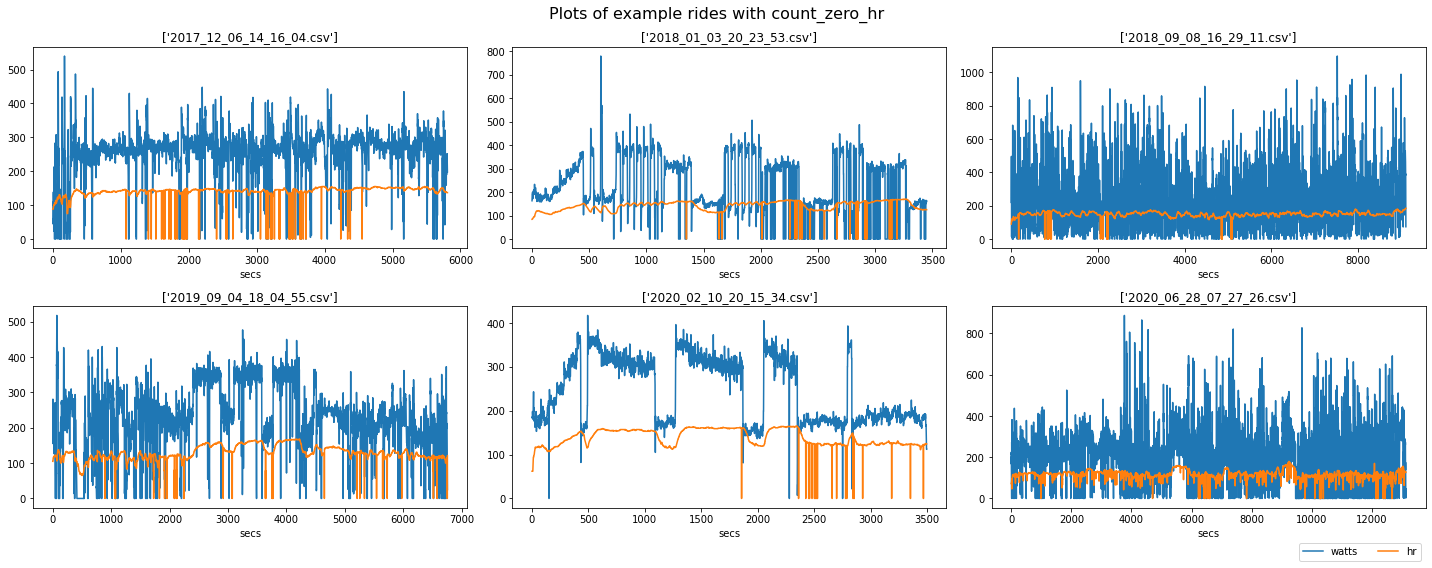

In [126]:
# invoke function
graph_ride_anomalies(df_raw, df_stats, 6, 'count_zero_hr', 2, 3)

In [127]:
# inspect top 5 rides with hr data flatliner where hr not equal to zero
df_stats[['filename','count_records','perc_consecutive_power_similar_values','consecutive_power_similar_values','hr_longest_zero_run','perc_count_zero_hr','count_zero_hr','perc_count_zero_power']].sort_values(by=['count_zero_hr'], ascending = False).head(10)

filename  count_records  \
179  2017_12_06_14_16_04.csv           5808   
530  2019_09_04_18_04_55.csv           6755   
668  2020_06_28_07_27_26.csv          13130   
340  2018_09_08_16_29_11.csv           9102   
192  2018_01_03_20_23_53.csv           3450   
604  2020_02_10_20_15_34.csv           3497   
304  2018_07_08_07_11_35.csv          27012   
191  2018_01_02_20_23_42.csv           2788   
621  2020_03_15_09_17_19.csv          15740   
587  2020_01_05_13_07_04.csv           7899   

     perc_consecutive_power_similar_values  consecutive_power_similar_values  \
179                                    0.0                                23   
530                                    2.0                               121   
668                                    0.0                                39   
340                                    0.0                                16   
192                                    1.0                                20   
604                                    0.0                                 5   
304                                    0.0                                96   
191                                    0.0                                 4   
621                                    0.0                                17   
587                                    2.0                               121   

     hr_longest_zero_run  perc_count_zero_hr  count_zero_hr  \
179                    2                 1.0             83   
530                    2                 1.0             59   
668                    2                 0.0             53   
340                    2                 0.0             42   
192                    2                 1.0             41   
604                    2                 1.0             38   
304                    2                 0.0             38   
191                    2                 1.0             37   
621                    2                 0.0             37   
587                    2                 0.0             36   

     perc_count_zero_power  
179                    4.0  
530                    8.0  
668                   10.0  
340                    7.0  
192                   14.0  
604                    0.0  
304                   12.0  
191                    1.0  
621                    1.0  
587                   44.0

**Observations**

Our zero heart rate problem seems almost reduced. Only a few rides have small numbers of zero heart rate. For now we have included a next dropout for files which have more than x% of zero heart rate. But we keep our data with max of 1% missing heart rate and will impute after correcting for the dropouts (which are visually still there). First get an idea on how long and often the zero heart rate periods occur across the files

In [128]:
def count_consecutive_zeros(s):
    v = np.diff(np.r_[0, s.values==0, 0])
    s = pd.value_counts(np.where(v == -1)[0] - np.where(v == 1)[0])
    s.index.name = "num_consecutive_zeros"
    s.name = "count"
    return s

file_zeros = df_raw.groupby('filename').hr.apply(count_consecutive_zeros).reset_index()

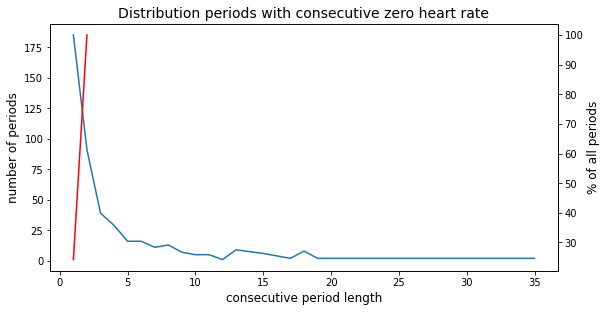

In [156]:
#https://stackoverflow.com/questions/29640588/pandas-calculate-length-of-consecutive-equal-values-from-a-grouped-dataframe
fig = plt.figure(figsize=(20,10)) 

ax1 = fig.add_subplot(221, sharex=None, sharey=None) 
file_zeros.groupby('hr').num_consecutive_zeros.sum().plot(ax=ax1)
ax1.set_xlabel('consecutive period length', fontsize=12)
ax1.set_ylabel('number of periods', fontsize=12)
ax1.set_title('Distribution periods with consecutive zero heart rate', fontsize=14);
ax2 = ax1.twinx() 
ax2.plot(((file_zeros.groupby('num_consecutive_zeros').hr.sum()/(sum(file_zeros.groupby('num_consecutive_zeros').hr.sum()))).cumsum())*100, color='r')
ax2.set_ylabel('% of all periods', fontsize=12);

95% of hr zero values are max 3 periods long. This was the rule we specified previously. We can for these cases at least start to impute. We take the consecutive previous value

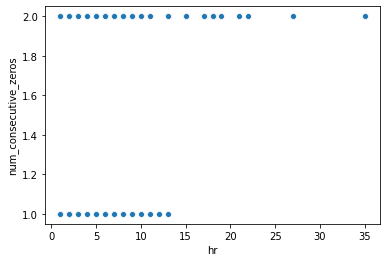

In [158]:
#sns.scatter(file_zeros[['hr','num_consecutive_zeros']], annot=True)
sns.scatterplot(data=file_zeros, x="hr", y="num_consecutive_zeros");

In [159]:
# add a column to ride data after we impute only those with max 3 zero values
# https://stackoverflow.com/questions/52752756/groupby-pandas-count-consecutive-zeros

grouped_cumsum_hr = df_raw['hr'].ne(df_raw['hr'].shift()).cumsum()
counts = df_raw.groupby(['filename', grouped_cumsum_hr])['hr'].transform('size')
df_raw['consec_hr_zero_count'] = np.where(df_raw['hr'].eq(0), counts, 0)

# Fills forward the zeros based on last seen non-zero value
df_raw['hr'] = df_raw['hr'].replace(0, np.nan)
df_raw['hr_shifted_t1'] = df_raw.groupby(['filename'])['hr'].fillna(method='ffill')

# reset nans to zero again; uneligant. Several functions tried to do it at once but nothing seemed to work
df_raw['hr'] = df_raw['hr'].replace(np.nan, 0)

#df_raw['hr_shifted_t1'] = df_raw.groupby(['filename'])['hr'].replace(to_replace=0, method='ffill')

In [160]:
# Conditional filling only for those records which have a zero for exactly 3 periods

df_raw['hr'] = np.where(((df_raw['consec_hr_zero_count']<=3) & (df_raw['hr']==0)), df_raw['hr_shifted_t1'] , df_raw['hr'])

df_raw.drop(columns=['hr_shifted_t1'], inplace=True)

# We then still have some periode longer than 4 sec. We deal with that later

In [161]:
# file zeros should be empty
file_zeros = df_raw.groupby('filename').hr.apply(count_consecutive_zeros).reset_index()
file_zeros.groupby('num_consecutive_zeros').hr.sum()

Series([], Name: hr, dtype: int64)

## Iteration 12

In order to identify heart rate drops we use an algorithm. For more explanation on the algorithm and its parameters see **Literature**. We set the parameters not too long since we often observed short heart rate drops

In [166]:
# function to define the algorithm

def thresholding_algo(y, lag, threshold, influence):

    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:


            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:

            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

In [168]:
# define parameters. We have experimented with the parameters (not documented) and found these parameters to signal the anomalies quite well (not related to a metric)

lag = 4 # the lag parameter determines how much data will be smoothed and how adaptive the algorithm is to changes in the long-term average of the data
threshold = 5 # the threshold parameter is the number of standard deviations from the moving mean above which the algorithm will classify a new datapoint as being a signal
influence = 0.9 # this parameter determines the influence of signals on the algorithm's detection threshold

In [169]:
# compute and add an extra column to identify deviation 

start_time = datetime.now()

# initiate empty DataFrame
result = pd.DataFrame()

for i in df_raw.filename.unique():
    results_df = pd.DataFrame(thresholding_algo(df_raw.loc[df_raw.filename==i].hr.to_numpy(), lag=lag, threshold=threshold, influence=influence))
    result = result.append(results_df, ignore_index=True)

# add the deviation columns to the dataframe
df_raw.reset_index(drop=True, inplace=True)
df_raw = pd.concat([df_raw, result], axis=1)
    
print('Time processing', datetime.now()- start_time)

Time processing 0:04:24.875307


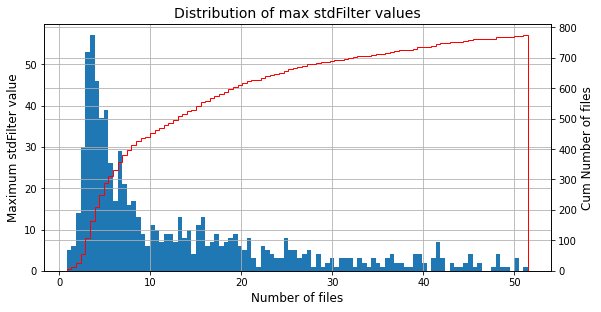

In [202]:
# Visualize the distribution of the maximum standard deviation filter values per ride

fig = plt.figure(figsize=(20,10)) 

ax1 = fig.add_subplot(221, sharex=None, sharey=None) 
df_raw.groupby('filename').stdFilter.max().sort_values(ascending=False).hist( bins=100, ax=ax1);
ax1.set_xlabel('Number of files', fontsize=12)
ax1.set_ylabel('Maximum stdFilter value', fontsize=12)
ax1.set_title('Distribution of max stdFilter values', fontsize=14);
ax2 = ax1.twinx() 
(df_raw.groupby('filename').stdFilter.max().sort_values(ascending=False).hist(histtype='step', density=False, bins=100,ax=ax2,cumulative=True, color='r'))
ax2.set_ylabel('Cum Number of files', fontsize=12);

We see that the majority of the rides have a maximum stdFilter value below 20. But we want to get an idea on what that heart rate data looks like

filename
2020_10_08_18_51_52.csv    51.500000
2020_11_20_17_06_33.csv    50.480194
2020_10_04_10_42_41.csv    50.012967
2020_03_17_20_40_20.csv    49.989999
2019_12_19_21_39_28.csv    49.000000
Name: stdFilter, dtype: float64


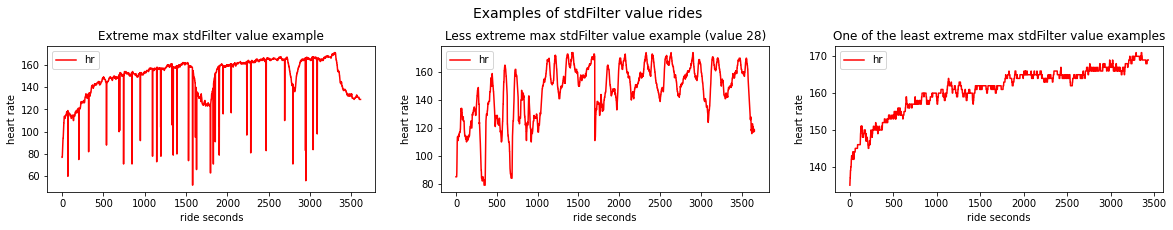

In [235]:
# Get an idea on a file with lager stdFilter values

print(df_raw.groupby('filename').stdFilter.max().sort_values(ascending=False)[:5])

# visualize example files
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3,figsize=(20,3))
fig.suptitle('Examples of stdFilter value rides', fontsize=14)

df_raw.loc[df_raw.filename==df_raw.groupby('filename').stdFilter.max().sort_values(ascending=False).index[0]][['hr']].reset_index(drop=True).plot(ax=ax1, color='r')
ax1.set_title('Extreme max stdFilter value example')
ax1.set_ylabel('heart rate')
ax1.set_xlabel('ride seconds');
df_raw.loc[df_raw.filename==df_raw.groupby('filename').stdFilter.max().sort_values(ascending=False).index[90]][['hr']].reset_index(drop=True).plot(ax=ax2, color='r')
ax2.set_title('Less extreme max stdFilter value example (value 28)')
ax2.set_ylabel('heart rate')
ax2.set_xlabel('ride seconds');
df_raw.loc[df_raw.filename==df_raw.groupby('filename').stdFilter.max().sort_values(ascending=False).index[-2]][['hr']].reset_index(drop=True).plot(ax=ax3, color='r')
ax3.set_title('One of the least extreme max stdFilter value examples')
ax3.set_ylabel('heart rate')
ax3.set_xlabel('ride seconds')
fig.subplots_adjust(top=0.80);

In [1749]:
#df_raw2.groupby('filename').stdFilter.max().sort_values(ascending=False);
#df_raw2.loc[df_raw2.filename=='2018_09_16_13_30_55.csv'][['hr']].plot(figsize=(20,4))

Based on iterative visualisations (not documented) we set the filter on 10. This is a very much subjective threshold by looking at what the ride files look like. 

We split files for further processing in problem files (files we have to adjust for anomalies) and no problem files

In [173]:
# set the threshold filter
threshold_stdFilter = 10

print('% of "problem" files', np.round(df_raw.loc[df_raw.stdFilter>threshold_stdFilter].filename.nunique()/df_raw.filename.nunique()*100))

# We split the file
df_raw_prob = df_raw[df_raw['filename'].isin(df_raw.loc[df_raw.stdFilter>threshold_stdFilter].filename.unique().tolist())]
df_raw_no_prob = df_raw[~df_raw['filename'].isin(df_raw.loc[df_raw.stdFilter>threshold_stdFilter].filename.unique().tolist())]

% of "problem" files 43.0


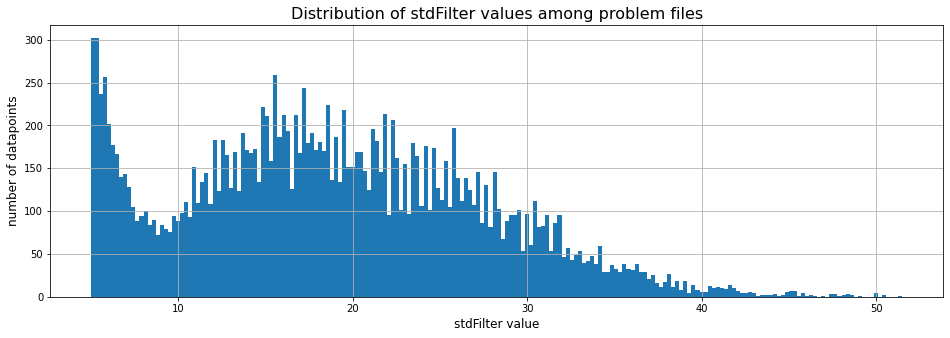

In [237]:
df_raw_prob.loc[df_raw_prob.stdFilter>5]['stdFilter'].hist(figsize=(16,5), bins=200);
plt.title('Distribution of stdFilter values among problem files', fontsize=16)
plt.xlabel('stdFilter value', fontsize=12)
plt.ylabel('number of datapoints', fontsize=12);

The filter process in based on a relatively short time period (lag = 4) to at least pinpoint drops (to non-zero). This results in that longer periods with drops are not flagged. Setting the lag period longer does not really help since this will flag normal HR changes (which lag of course). So for this we add another indicator for maximum 20 periods of drop period. This will act as another filter AND as point filter to filter out those drops.

In [238]:
# We only code the drops since we often see a drop and not a peak. The 'normal' short peaks will be filtered later on using the stdFilter

# minimum threshold for drop identification
threshold_hr_sec_sec_drops = -10

df_deviations = pd.DataFrame()

start_time = datetime.now()
#file  = df_correct.loc[df_correct.filename=='2020_07_12_06_50_35.csv']

for i in df_raw_prob.filename.unique():
    
    df_init = df_raw_prob.loc[df_raw_prob.filename==i]
    df_init['hr_drop_ind'] = np.where(df_init.hr-df_init.hr.shift(1)< threshold_hr_sec_sec_drops ,1, 0)
    df_init['hr_drop_ind'] = np.where(((df_init.hr_drop_ind.shift(1)==1) & (df_init.hr-df_init.hr.shift(2)< threshold_hr_sec_sec_drops)),1,df_init['hr_drop_ind'])
    df_init['hr_drop_ind'] = np.where(((df_init.hr_drop_ind.shift(1)==1) & (df_init.hr-df_init.hr.shift(3)< threshold_hr_sec_sec_drops)),1,df_init['hr_drop_ind'])
    df_init['hr_drop_ind'] = np.where(((df_init.hr_drop_ind.shift(1)==1) & (df_init.hr-df_init.hr.shift(4)< threshold_hr_sec_sec_drops)),1,df_init['hr_drop_ind'])
    df_init['hr_drop_ind'] = np.where(((df_init.hr_drop_ind.shift(1)==1) & (df_init.hr-df_init.hr.shift(5)< threshold_hr_sec_sec_drops)),1,df_init['hr_drop_ind'])
    df_init['hr_drop_ind'] = np.where(((df_init.hr_drop_ind.shift(1)==1) & (df_init.hr-df_init.hr.shift(6)< threshold_hr_sec_sec_drops)),1,df_init['hr_drop_ind'])
    df_init['hr_drop_ind'] = np.where(((df_init.hr_drop_ind.shift(1)==1) & (df_init.hr-df_init.hr.shift(7)< threshold_hr_sec_sec_drops)),1,df_init['hr_drop_ind'])
    df_init['hr_drop_ind'] = np.where(((df_init.hr_drop_ind.shift(1)==1) & (df_init.hr-df_init.hr.shift(8)< threshold_hr_sec_sec_drops)),1,df_init['hr_drop_ind'])
    df_init['hr_drop_ind'] = np.where(((df_init.hr_drop_ind.shift(1)==1) & (df_init.hr-df_init.hr.shift(9)< threshold_hr_sec_sec_drops)),1,df_init['hr_drop_ind'])
    df_init['hr_drop_ind'] = np.where(((df_init.hr_drop_ind.shift(1)==1) & (df_init.hr-df_init.hr.shift(10)< threshold_hr_sec_sec_drops)),1,df_init['hr_drop_ind'])
    df_init['hr_drop_ind'] = np.where(((df_init.hr_drop_ind.shift(1)==1) & (df_init.hr-df_init.hr.shift(11)< threshold_hr_sec_sec_drops)),1,df_init['hr_drop_ind'])
    df_init['hr_drop_ind'] = np.where(((df_init.hr_drop_ind.shift(1)==1) & (df_init.hr-df_init.hr.shift(12)< threshold_hr_sec_sec_drops)),1,df_init['hr_drop_ind'])
    df_init['hr_drop_ind'] = np.where(((df_init.hr_drop_ind.shift(1)==1) & (df_init.hr-df_init.hr.shift(13)< threshold_hr_sec_sec_drops)),1,df_init['hr_drop_ind'])
    df_init['hr_drop_ind'] = np.where(((df_init.hr_drop_ind.shift(1)==1) & (df_init.hr-df_init.hr.shift(14)< threshold_hr_sec_sec_drops)),1,df_init['hr_drop_ind'])
    df_init['hr_drop_ind'] = np.where(((df_init.hr_drop_ind.shift(1)==1) & (df_init.hr-df_init.hr.shift(15)< threshold_hr_sec_sec_drops)),1,df_init['hr_drop_ind'])
    df_init['hr_drop_ind'] = np.where(((df_init.hr_drop_ind.shift(1)==1) & (df_init.hr-df_init.hr.shift(16)< threshold_hr_sec_sec_drops)),1,df_init['hr_drop_ind'])
    df_init['hr_drop_ind'] = np.where(((df_init.hr_drop_ind.shift(1)==1) & (df_init.hr-df_init.hr.shift(17)< threshold_hr_sec_sec_drops)),1,df_init['hr_drop_ind'])
    df_init['hr_drop_ind'] = np.where(((df_init.hr_drop_ind.shift(1)==1) & (df_init.hr-df_init.hr.shift(18)< threshold_hr_sec_sec_drops)),1,df_init['hr_drop_ind'])
    df_init['hr_drop_ind'] = np.where(((df_init.hr_drop_ind.shift(1)==1) & (df_init.hr-df_init.hr.shift(19)< threshold_hr_sec_sec_drops)),1,df_init['hr_drop_ind'])
    df_init['hr_drop_ind'] = np.where(((df_init.hr_drop_ind.shift(1)==1) & (df_init.hr-df_init.hr.shift(20)< threshold_hr_sec_sec_drops)),1,df_init['hr_drop_ind'])

    df_deviations = df_deviations.append(df_init, ignore_index=True)
    
print('Time processing', datetime.now()-start_time)

Time processing 0:02:23.331616


In [239]:
# We remove rides which have more than x% drops in the data. The lower the more files we would loose. 5 seems OK as threshold

# set threshold
threshold_perc_hr_drop = 5

print('We had ',df_deviations.filename.unique().shape[0],'files in the problem files')

# In between result with % of drops per file
hr_drops = (df_deviations.groupby('filename').hr_drop_ind.sum()/df_deviations.groupby('filename').size()*100).reset_index().rename(columns={0:'perc_hr_drop'})

df_deviations = df_deviations[~df_deviations['filename'].isin(hr_drops.loc[hr_drops.perc_hr_drop > threshold_perc_hr_drop].filename.unique().tolist())]

print('We now have ',df_deviations.filename.unique().shape[0],'files in the problem files')

We had  331 files in the problem files
We now have  330 files in the problem files


In [240]:
(df_deviations.groupby('filename').hr_drop_ind.sum()/df_deviations.groupby('filename').size()*100).sort_values(ascending=False)[:10]

filename
2018_08_06_10_03_31.csv    4.691211
2019_10_17_18_28_41.csv    4.364326
2017_07_16_11_34_59.csv    3.732691
2017_08_26_15_01_44.csv    3.593272
2019_03_17_14_21_39.csv    3.476907
2020_07_23_16_20_20.csv    3.421132
2018_03_24_10_17_12.csv    3.128555
2020_07_04_10_57_31.csv    2.947846
2020_06_28_07_27_26.csv    2.772277
2017_07_29_16_05_43.csv    2.713178
dtype: float64

Next we still are left with our filter procedure. We had a filter from the algoritm AND the filter we made for periods of HR drops
The solution for keeping the data is a combination of the two:

    (a) We want to exclude the heart drop periods. This part could be analysed further especially for periods in which there are long drops. Maybe interpolation could be used for that, but very long periods with drops still will be a concern
    
    (b) We will still be left with some drops which we filter with the algo filter. A suitable setting seems to be around 10

In [241]:
# filter threhold
stdFilter_value = 10

print('We had ',df_deviations.shape[0],'records in the problem files')

# apply the combined rule
df_deviations = df_deviations.loc[(df_deviations.hr_drop_ind==0) & (df_deviations.stdFilter < stdFilter_value)]

print('Now we have ',df_deviations.shape[0],'records in the problem files')

We had  2212700 records in the problem files
Now we have  2187447 records in the problem files


In [242]:
# put all data back together
df_deviations = df_deviations[['secs','cad','hr','watts','alt','slope','temp','filename','date']]

print('We have ',df_deviations.shape[0],'records in the problem files')

df_raw_no_prob = df_raw_no_prob[['secs','cad','hr','watts','alt','slope','temp','filename','date']]

print('We have ',df_raw_no_prob.shape[0],'records in the no problem files')

df_raw = pd.concat([df_raw_no_prob,df_deviations], axis=0)

# reset the index
df_raw.reset_index(drop=True, inplace=True)

print('We have in total ',df_raw.shape[0],'records')
print('We have in total ',df_raw.filename.unique().shape[0],'files')

We have  2187447 records in the problem files
We have  1872159 records in the no problem files
We have in total  4059606 records
We have in total  772 files


In [243]:
# adjust seconds for plotting
df_raw['secs'] = df_raw.groupby('filename').cumcount()+1

df_raw['hr_power_zero'] = np.where((df_raw['hr']==0) & (df_raw['watts'] == 0) , 0,1)
df_raw['hr_power_ratio'] = np.round(df_raw['watts']/df_raw['hr']*100, 2)

# add some indicators for consecutive similar values for variables that might be used for modelling further
df_raw['consecutive_hr_similar_values'] = df_raw.hr.groupby([df_raw.filename, df_raw.hr.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_power_similar_values'] = df_raw.watts.groupby([df_raw.filename, df_raw.watts.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_cad_similar_values'] = df_raw.cad.groupby([df_raw.filename, df_raw.cad.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_hr_power_ratio_similar_values'] = df_raw.hr_power_ratio.groupby([df_raw.filename, df_raw.hr_power_ratio.diff().ne(0).cumsum()]).transform('size')

# apply the function for ride statistics
df_stats = ride_stats_calculation(df_raw)
df_stats.head(5)

filename  count_records     mean_hr   mean_cad  mean_power  \
0  2017_01_02_20_00_03.csv           3653  151.170819  84.703258  252.539283   
1  2017_01_03_20_07_36.csv           3065  146.652202  82.800653  255.368352   
2  2017_01_07_19_57_46.csv           5286  142.734960  86.547295  210.615210   
3  2017_01_08_18_02_53.csv           3310  141.571601  75.634139  222.556193   
4  2017_01_10_19_48_18.csv           3562  132.856822  83.324537  195.807692   

   mean_temp   mean_alt  mean_slope  min_hr  max_hr  min_cad  max_cad  \
0   7.175198  -9.970600    0.008560    50.0   175.0        0      103   
1   8.397716  33.758238    0.051991   100.0   170.0        0       97   
2   6.706773   0.929550   -0.007759    49.0   167.0        0      110   
3   9.961329  15.660060    0.015757    59.0   168.0        0       98   
4  10.169006   2.157777   -0.003963    80.0   174.0        0      103   

   min_power  max_power  min_temp  max_temp  min_alt  max_alt  min_slope  \
0          0        375         6        14    -11.6     -8.6  -1.835940   
1          0        363         7        16     29.2     37.6  -1.407380   
2          0        433         5        15     -0.4      1.8  -2.824860   
3          0        380         9        17     14.0     17.4  -0.932401   
4          0        369         9        16      0.8      3.8  -0.611377   

   max_slope     std_hr     std_power  cv_hr  cv_power  count_zero_hr  \
0   1.384620  20.121043   7774.461011   0.13     30.79              0   
1   1.398600  16.084239   6477.967732   0.11     25.37              0   
2   2.869440  16.010023   8152.240556   0.11     38.71              0   
3   0.943315  18.109173  11317.756134   0.13     50.85              0   
4   7.299270  20.651132   9470.928186   0.16     48.37              0   

   count_zero_cad  count_zero_power  perc_count_zero_hr  perc_count_zero_cad  \
0              62               122                 0.0                  2.0   
1              38                92                 0.0                  1.0   
2             367               654                 0.0                  7.0   
3             247               437                 0.0                  7.0   
4             157               296                 0.0                  4.0   

   perc_count_zero_power  count_zero_hr_power  perc_count_zero_hr_power  \
0                    3.0                    0                       0.0   
1                    3.0                    0                       0.0   
2                   12.0                    0                       0.0   
3                   13.0                    0                       0.0   
4                    8.0                    0                       0.0   

   hr_longest_zero_run  cad_longest_zero_run  power_longest_zero_run  \
0                    0                     6                       7   
1                    0                     6                       7   
2                    0                    11                      14   
3                    0                    12                      16   
4                    0                    20                      21   

   perc_hr_longest_zero_run  perc_cad_longest_zero_run  \
0                       0.0                        0.0   
1                       0.0                        0.0   
2                       0.0                        0.0   
3                       0.0                        0.0   
4                       0.0                        1.0   

   perc_power_longest_zero_run  count_power_extremes  count_cad_extremes  \
0                          0.0                     0                   0   
1                          0.0                     0                   0   
2                          0.0                     0                   0   
3                          0.0                     0                   0   
4                          1.0                     0                   0   

   perc_power_extremes  perc_ca

Just inspect some previous problem files

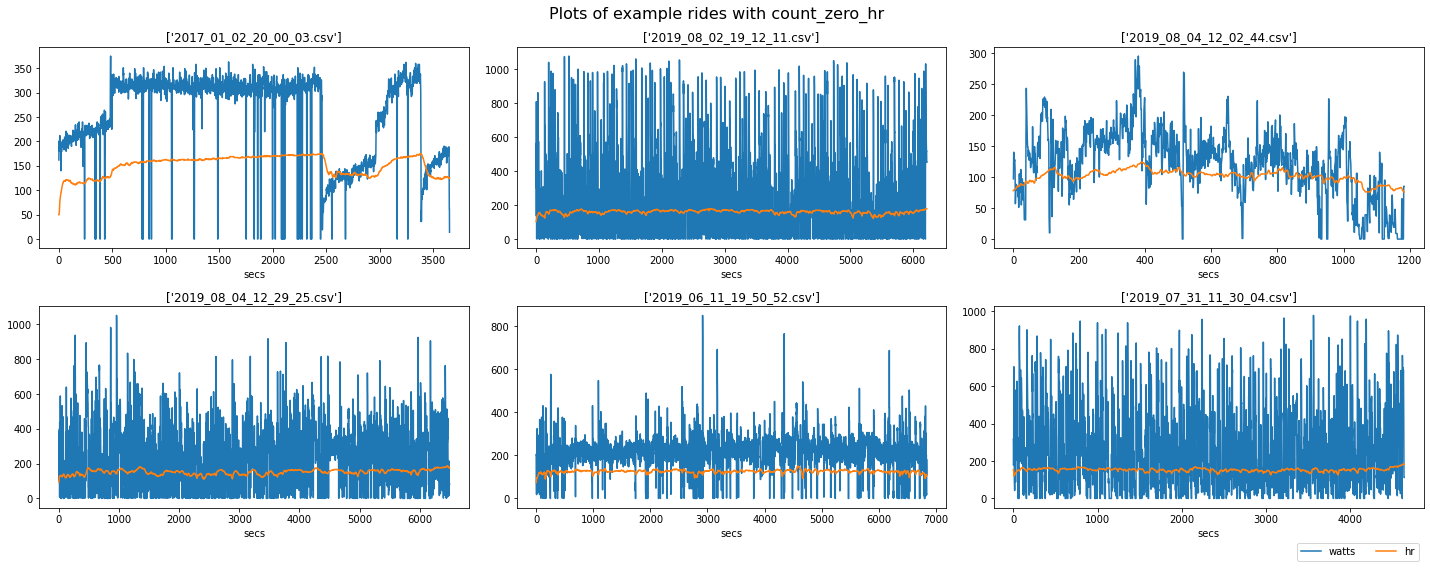

In [244]:
# invoke function
graph_ride_anomalies(df_raw, df_stats, 6, 'count_zero_hr', 2, 3)

### Here we look at power extremes and cadence extremes based on previous set values for extremes

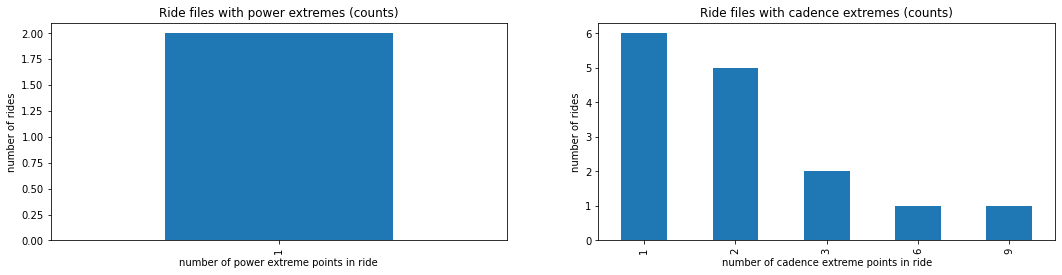

In [248]:
# using the variable axs for multiple Axes
fig, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(18,4))

df_stats.count_power_extremes.value_counts()[1:].plot(kind='bar', ax=ax1);
ax1.set_title('Ride files with power extremes (counts)')
ax1.set_xlabel('number of power extreme points in ride')
ax1.set_ylabel('number of rides')
df_stats.count_cad_extremes.value_counts().sort_index()[1:].plot(kind='bar', ax=ax2)
ax2.set_title('Ride files with cadence extremes (counts)')
ax2.set_xlabel('number of cadence extreme points in ride')
ax2.set_ylabel('number of rides');

**Observations** 

There are only very few files with a few power/cadence extremes

In [251]:
# We delete those points (not the complete files)

df_raw = df_raw.loc[df_raw.watts < rider_params['rider_max_watts']]
df_raw = df_raw.loc[df_raw.cad < rider_params['rider_max_cad']]

df_raw.reset_index(drop=True, inplace=True)

# adjust seconds for plotting
df_raw['secs'] = df_raw.groupby('filename').cumcount()+1

df_raw['hr_power_zero'] = np.where((df_raw['hr']==0) & (df_raw['watts'] == 0) , 0,1)
df_raw['hr_power_ratio'] = np.round(df_raw['watts']/df_raw['hr']*100, 2)

# add some indicators for consecutive similar values for variables that might be used for modelling further
df_raw['consecutive_hr_similar_values'] = df_raw.hr.groupby([df_raw.filename, df_raw.hr.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_power_similar_values'] = df_raw.watts.groupby([df_raw.filename, df_raw.watts.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_cad_similar_values'] = df_raw.cad.groupby([df_raw.filename, df_raw.cad.diff().ne(0).cumsum()]).transform('size')
df_raw['consecutive_hr_power_ratio_similar_values'] = df_raw.hr_power_ratio.groupby([df_raw.filename, df_raw.hr_power_ratio.diff().ne(0).cumsum()]).transform('size')

# apply the function for ride statistics
df_stats = ride_stats_calculation(df_raw)
df_stats.head(5)

filename  count_records     mean_hr   mean_cad  mean_power  \
0  2017_01_02_20_00_03.csv           3653  151.170819  84.703258  252.539283   
1  2017_01_03_20_07_36.csv           3065  146.652202  82.800653  255.368352   
2  2017_01_07_19_57_46.csv           5286  142.734960  86.547295  210.615210   
3  2017_01_08_18_02_53.csv           3310  141.571601  75.634139  222.556193   
4  2017_01_10_19_48_18.csv           3562  132.856822  83.324537  195.807692   

   mean_temp   mean_alt  mean_slope  min_hr  max_hr  min_cad  max_cad  \
0   7.175198  -9.970600    0.008560    50.0   175.0        0      103   
1   8.397716  33.758238    0.051991   100.0   170.0        0       97   
2   6.706773   0.929550   -0.007759    49.0   167.0        0      110   
3   9.961329  15.660060    0.015757    59.0   168.0        0       98   
4  10.169006   2.157777   -0.003963    80.0   174.0        0      103   

   min_power  max_power  min_temp  max_temp  min_alt  max_alt  min_slope  \
0          0        375         6        14    -11.6     -8.6  -1.835940   
1          0        363         7        16     29.2     37.6  -1.407380   
2          0        433         5        15     -0.4      1.8  -2.824860   
3          0        380         9        17     14.0     17.4  -0.932401   
4          0        369         9        16      0.8      3.8  -0.611377   

   max_slope     std_hr     std_power  cv_hr  cv_power  count_zero_hr  \
0   1.384620  20.121043   7774.461011   0.13     30.79              0   
1   1.398600  16.084239   6477.967732   0.11     25.37              0   
2   2.869440  16.010023   8152.240556   0.11     38.71              0   
3   0.943315  18.109173  11317.756134   0.13     50.85              0   
4   7.299270  20.651132   9470.928186   0.16     48.37              0   

   count_zero_cad  count_zero_power  perc_count_zero_hr  perc_count_zero_cad  \
0              62               122                 0.0                  2.0   
1              38                92                 0.0                  1.0   
2             367               654                 0.0                  7.0   
3             247               437                 0.0                  7.0   
4             157               296                 0.0                  4.0   

   perc_count_zero_power  count_zero_hr_power  perc_count_zero_hr_power  \
0                    3.0                    0                       0.0   
1                    3.0                    0                       0.0   
2                   12.0                    0                       0.0   
3                   13.0                    0                       0.0   
4                    8.0                    0                       0.0   

   hr_longest_zero_run  cad_longest_zero_run  power_longest_zero_run  \
0                    0                     6                       7   
1                    0                     6                       7   
2                    0                    11                      14   
3                    0                    12                      16   
4                    0                    20                      21   

   perc_hr_longest_zero_run  perc_cad_longest_zero_run  \
0                       0.0                        0.0   
1                       0.0                        0.0   
2                       0.0                        0.0   
3                       0.0                        0.0   
4                       0.0                        1.0   

   perc_power_longest_zero_run  count_power_extremes  count_cad_extremes  \
0                          0.0                     0                   0   
1                          0.0                     0                   0   
2                          0.0                     0                   0   
3                          0.0                     0                   0   
4                          1.0                     0                   0   

   perc_power_extremes  perc_ca

As a final step there is the possibility to remove rides which are shorter than a certain length

In [252]:
# define threshold ride length
threshold_count_records = 900 # threshold in seconds, the higher the threshold the more you drop

print('We had ',df_stats.shape[0],'ride files')

df_files_drop = df_stats.loc[(df_stats.count_records<threshold_count_records)]

df_stats = df_stats[~df_stats['filename'].isin(df_files_drop.filename.unique().tolist())]

print('We now have ',df_stats.shape[0],'ride files')

# drop files in raw data
df_raw = df_raw[~df_raw['filename'].isin(df_files_drop.filename.unique().tolist())]

We had  772 ride files
We now have  770 ride files


Save the file as pickle file to be used in the notebook **2. Feature engineering.ipynb**

In [155]:
# Keep relevant variables in DataFrame
df_raw = df_raw[['filename','date','secs','cad','hr','watts','alt','slope','temp']]

# Save to pickle
df_raw.to_pickle('df_modelset_rider1.pickle')

## Literature

* Algorithm to detect heart rate anomalies (drops) https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data